# Multi-Model Analysis : Priestley-Taylor (PETPT) and Penaman-Monteith Based Models (PETPNO, PETPEN, PETDYN)
This notebook focuses on answering the question: how can AutoMATES leverage the information extracted from source code and free text to improve modelers ability to visualize input sensitivity in a multiple crop models? We shall demonstrate the ability of AutoMATES to analyze these models from the DSST codebase. In addition, results of a comparative study of various models using global sensitivity analysis is also included in the document.

## Visualization goals
- Show that S1 analysis over the whole range of all variables demonstrates a high S1 value for TMAX
- Show that we can use static program analysis to determine that TMAX controls a piecewise function
- Show that we can use evidence from TR when breaking up the bound range of TMAX to reflect the piecewise nature of the function
- Show the updated S1/S2 plots for the broken down ranges

In [39]:
from penman import SensitivityModel
from model_analysis.visualization import SensitivityVisualizer
from IPython.display import display

##### List of Sample Sizes #####

sample_list = [10**x for x in range(1, 6)]


# Setting SA method to deploy
method = 'Sobol'


*** ALL OUTPUT FILES LIVE IN [.]
*** ALL OUTPUT FILES LIVE IN [.]
*** ALL OUTPUT FILES LIVE IN [.]
*** ALL OUTPUT FILES LIVE IN [.]
*** ALL OUTPUT FILES LIVE IN [.]
*** ALL OUTPUT FILES LIVE IN [.]


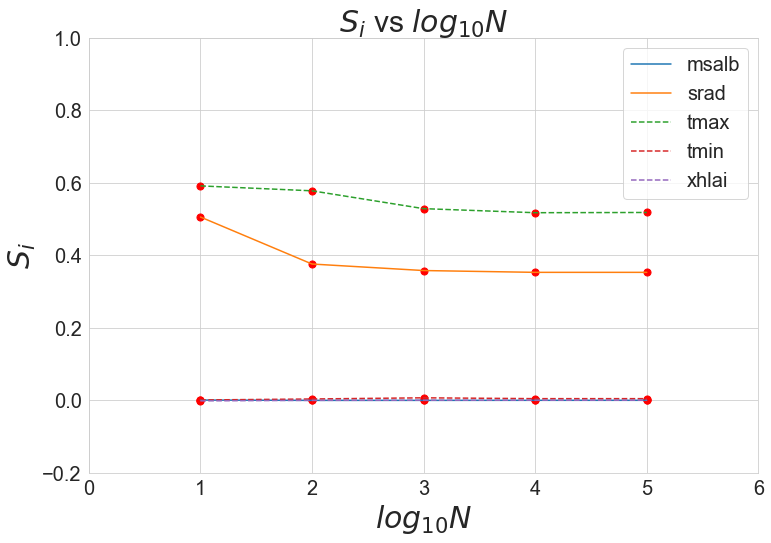

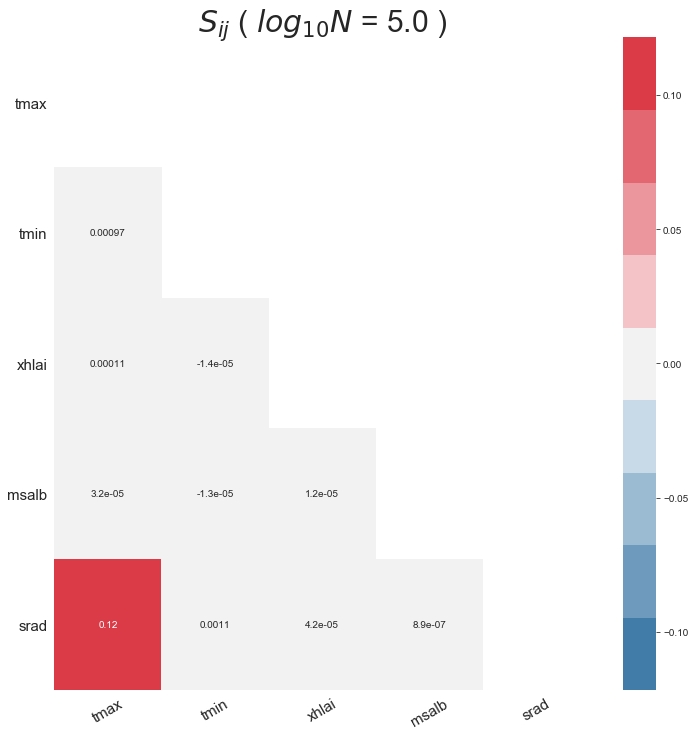

In [92]:
# Choice of Model
model = 'PETPT'

# Using the full-range bounds at first
bounds = {
        'tmax':[-10.0, 50.0],
        'tmin':[0.0, 23.9],
        'srad': [2.45, 27.8],
        'msalb': [0.18, 0.2],
        'xhlai': [0.0, 4.77]
    }

SM = SensitivityModel(model, bounds, sample_list, method)

decimal=4
df_PETPT_S1, df_PETPT_ST = SM.generate_dataframe(decimal)

indices_lst = SM.generate_indices()

component = 'S1'
SM.sensitivity_plots(indices_lst, component)
component = 'S2'
SM.sensitivity_plots(indices_lst, component)

### Analysis of the above results
As we can see from the S1 plot abovwe, it appears that TMAX and SRAD play critical roles in determining the uncertainty of the output here. We can inspect the source code using AutoMATES to try and determine why these two variables play such a significant role. Below is a code-block from the PETPT Fortran source code:
```fortran
      SLANG = SRAD*23.923
      EEQ = SLANG*(2.04E-4-1.83E-4*ALBEDO)*(TD+29.0)
      EO = EEQ*1.1

      IF (TMAX .GT. 35.0) THEN
        EO = EEQ*((TMAX-35.0)*0.05+1.1)
      ELSE IF (TMAX .LT. 5.0) THEN
        EO = EEQ*0.01*EXP(0.18*(TMAX+20.0))
      ENDIF

      EO = MAX(EO,0.0001)
```
In this code-block we can see that TMAX plays a critical role at the end of the PETPT function. This role is to divide the function into three piecewise components based upon the value of TMAX. AutoMATES can detect this using static code analysis on the conditional variables included in the model code.

Using this along with text-reading knowledge of the parameter bounds for TMAX, we can divide the total range of values for TMAX into three separate bound ranges that we can use for further analysis:
1. -10.0ºC -- 5.0ºC
2. 5.0ºC -- 35.0ºC
3. 35.0ºC -- 55.0ºC

Below we show the S1/S2 results for these three different bound ranges.

### Result Set 1 - TMAX : [5.0,  35.0]
Notice for this first result set that we are working with non-extreme values of TMAX. When the values for TMAX are no longer extreme, we see that it drops off significantly from the S1 indices and allows other variables to show how much more of an important role they play in determining model output.

#### Key insights
- SRAD now dominates all other uncertainty sources in the S1 indices
- The interaction between SRAD and TMAX is now shown to be an important S2 index

*** ALL OUTPUT FILES LIVE IN [.]
*** ALL OUTPUT FILES LIVE IN [.]
*** ALL OUTPUT FILES LIVE IN [.]
*** ALL OUTPUT FILES LIVE IN [.]
*** ALL OUTPUT FILES LIVE IN [.]
*** ALL OUTPUT FILES LIVE IN [.]


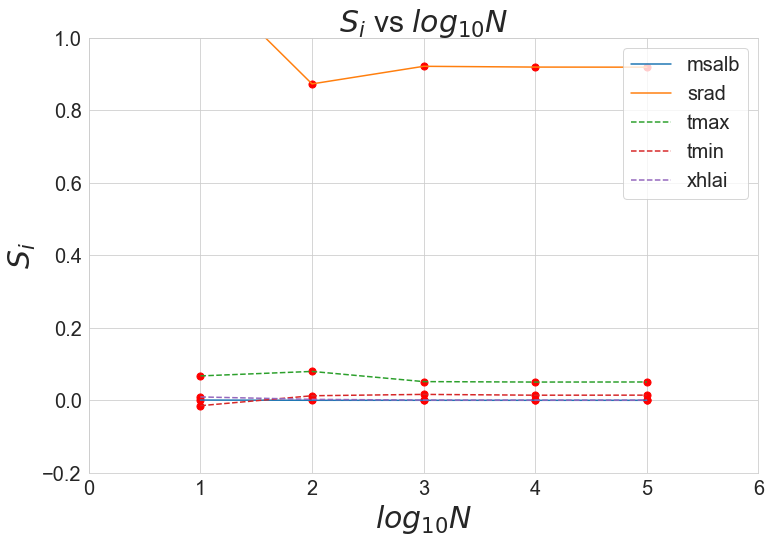

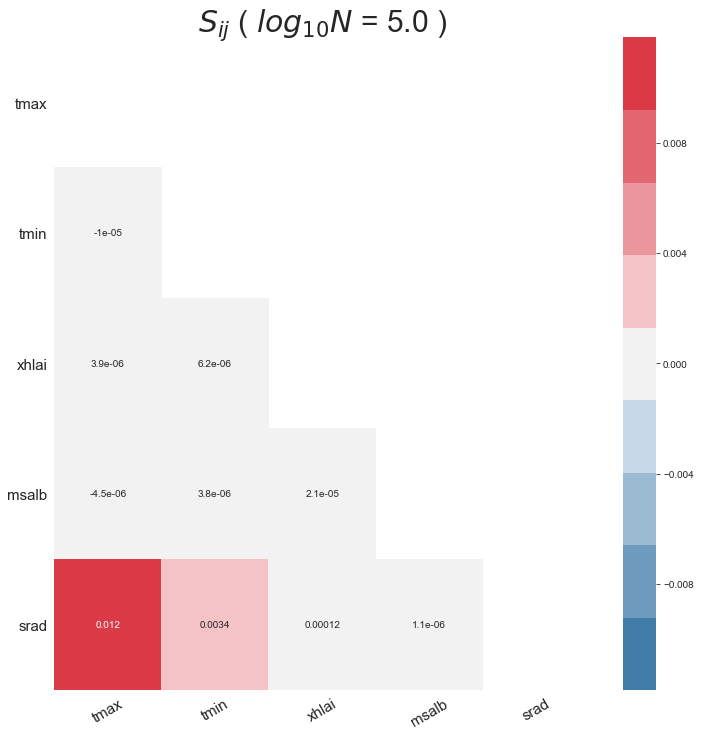

In [93]:
# Choosing the bound set
bounds = {
        'tmax':[5.0, 35.0],
        'tmin':[0.0, 23.9],
        'srad': [2.45, 27.8],
        'msalb': [0.18, 0.2],
        'xhlai': [0.0, 4.77]
    }

SM = SensitivityModel(model, bounds, sample_list, method)

decimal = 4
df_PETPT_S1_set1, df_PETPT_ST_set1 = SM.generate_dataframe(decimal)

indices_lst = SM.generate_indices()

SM.sensitivity_plots(indices_lst, "S1")
SM.sensitivity_plots(indices_lst, "S2")

### Result Set 2 - TMAX : [-10.0,  4.99]
For this result set we are looking at the extreme lower end of values for TMAX. Here we see that TMAX is an even greater contributor to S1 sensitivity than over the whole range. This is likely due to the scaling of EO done by an exponential term involving TMAX in this portion of the piecewise function.

*** ALL OUTPUT FILES LIVE IN [.]
*** ALL OUTPUT FILES LIVE IN [.]
*** ALL OUTPUT FILES LIVE IN [.]
*** ALL OUTPUT FILES LIVE IN [.]
*** ALL OUTPUT FILES LIVE IN [.]
*** ALL OUTPUT FILES LIVE IN [.]


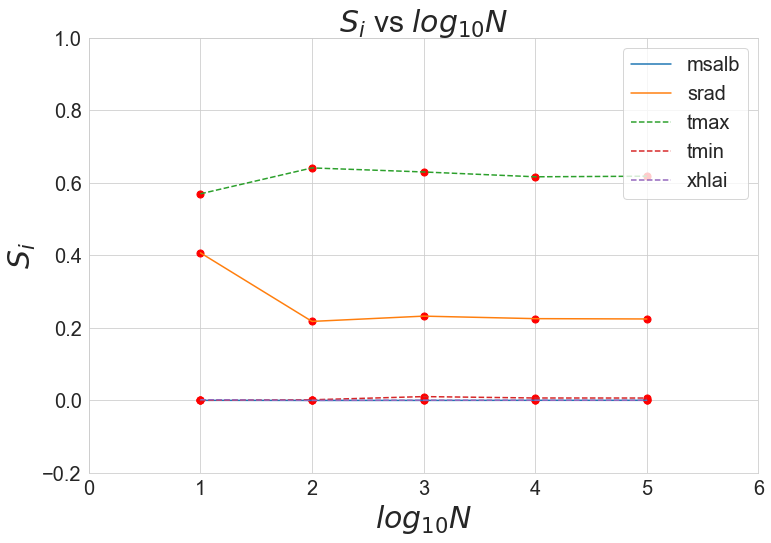

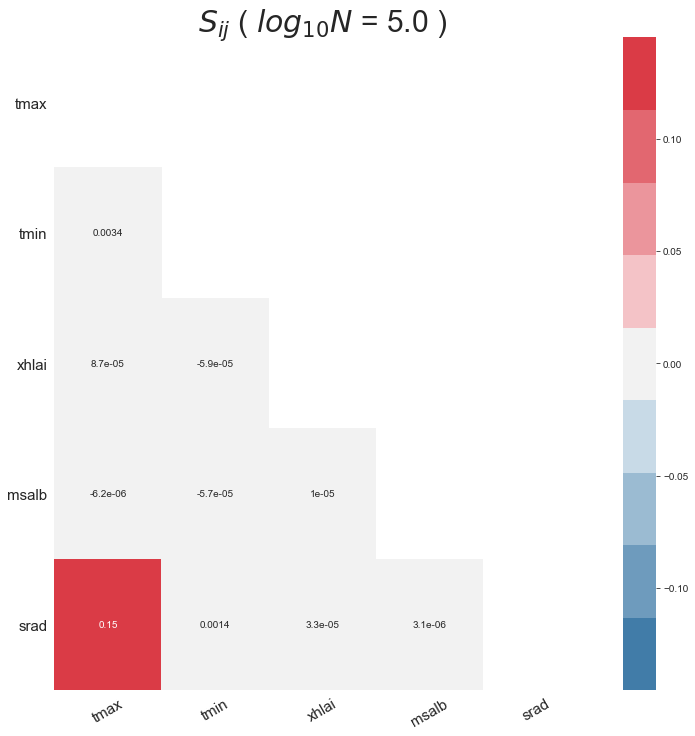

In [51]:
bounds = {
        'tmax':[-10.0, 4.99],
        'tmin':[0.0, 23.9],
        'srad': [2.45, 27.8],
        'msalb': [0.18, 0.2],
        'xhlai': [0.0, 4.77]
    }

SM = SensitivityModel(model, bounds, sample_list, method)

decimal=4
df_PETPT_S1_set2, df_PETPT_ST_set2 = SM.generate_dataframe(decimal)

indices_lst = SM.generate_indices()

SM.sensitivity_plots(indices_lst, "S1")
SM.sensitivity_plots(indices_lst, "S2")

### Result Set 3 - TMAX : [35.1,  55.0]
Here we are testing the extreme high end of values for TMAX. For this bound range we are now observing:
- SRAD is the largest contributor to the S1 sensitivity
- TMAX is still a large contributor to the S1 sensitivity
- The total S1 sensitivity has increased dramatically, causing a large decrease in S2 total sensitivity which lowers the impact of the TMAX/SRAD interaction term. This is likely due to the scaling of EO by TMAX in this branch of the piecewise function

In [ ]:
bounds = {
        'tmax':[35.1, 55.0],
        'tmin':[0.0, 23.9],
        'srad': [2.45, 27.8],
        'msalb': [0.18, 0.2],
        'xhlai': [0.0, 4.77]
    }

SM = SensitivityModel(model, bounds, sample_list, method)

decimal=4
df_PETPT_S1_set3, df_PETPT_ST_set3 = SM.generate_dataframe(decimal)

indices_lst = SM.generate_indices()

component = 'S1'
SM.sensitivity_plots(indices_lst, component)
component = 'S2'
SM.sensitivity_plots(indices_lst, component)

### XHLAI : [-5.0, 5.0]; TMAX : [5.0, 35.0]

In [ ]:
# Choosing the bound set
bounds = {
        'tmax':[5.0, 35.0],
        'tmin':[0.0, 23.9],
        'srad': [2.45, 27.8],
        'msalb': [0.18, 0.2],
        'xhlai': [-5.0, 5.0]
    }

SM = SensitivityModel(model, bounds, sample_list, method)
decimal=4
df_PETPT_S1_xhlai, df_PETPT_ST_xhlai = SM.generate_dataframe(decimal)
indices_lst = SM.generate_indices()

SM.sensitivity_plots(indices_lst, "S1")
SM.sensitivity_plots(indices_lst, "S2")

### SRAD : [0.0, 5.0]; TMAX : [5.0, 35.0]

*** ALL OUTPUT FILES LIVE IN [.]
*** ALL OUTPUT FILES LIVE IN [.]
*** ALL OUTPUT FILES LIVE IN [.]
*** ALL OUTPUT FILES LIVE IN [.]
*** ALL OUTPUT FILES LIVE IN [.]
*** ALL OUTPUT FILES LIVE IN [.]


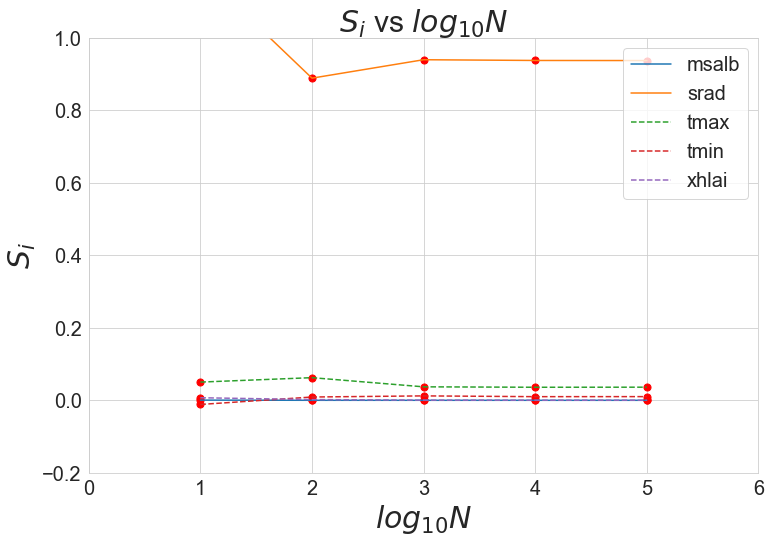

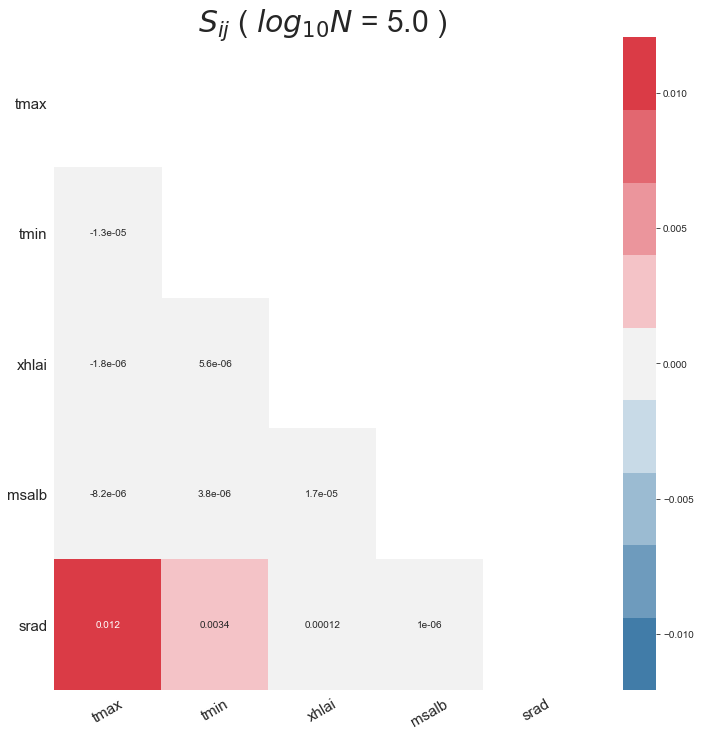

In [59]:
model='PETPT'
bounds = {
        'tmax':[5.0, 35.0],
        'tmin':[0.0, 23.9],
        'srad': [0.0, 5.0],
        'msalb': [0.18, 0.2],
        'xhlai': [0.0, 4.77]
    }

SM = SensitivityModel(model, bounds, sample_list, method)

decimal=4
df_PETPT_S1_srad, df_PETPT_ST_srad = SM.generate_dataframe(decimal)

indices_lst = SM.generate_indices()

SM.sensitivity_plots(indices_lst, "S1")
SM.sensitivity_plots(indices_lst, "S2")

## PETPNO

### Result Set 1 - TMAX  : [5.0,  35.0]

- SRAD still has the highest S1 index
- TMAX, TMIN, TDEW, CLOUDS all have moderately strong indices
- (TMAX, SRAD), (TDEW, SRAD) have S2 indices above 0.01 cut-off

*** ALL OUTPUT FILES LIVE IN [.]
*** ALL OUTPUT FILES LIVE IN [.]
*** ALL OUTPUT FILES LIVE IN [.]
*** ALL OUTPUT FILES LIVE IN [.]
*** ALL OUTPUT FILES LIVE IN [.]
*** ALL OUTPUT FILES LIVE IN [.]


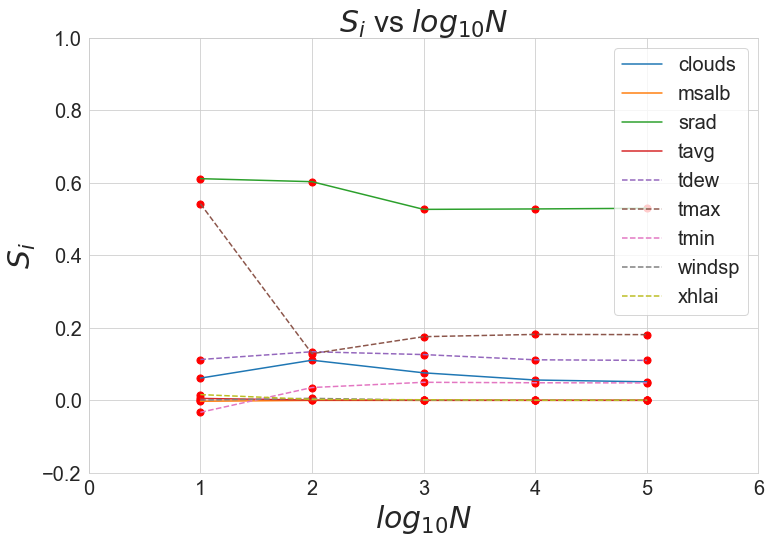

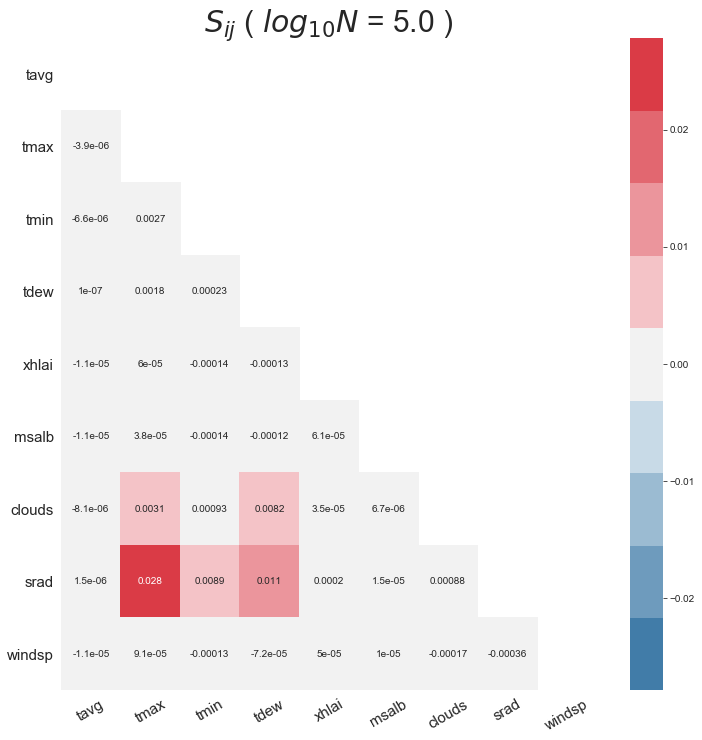

In [94]:
model = 'PETPNO'

bounds = {
        'tmax':[5.0, 35.0],
        'tmin':[0.0, 23.9],
        'srad': [2.45, 27.8],
        'msalb': [0.18, 0.2],
        'xhlai': [0.0, 4.77],
        'tavg': [8.0, 31],
        'tdew': [8.0, 31],
        'windsp': [0.0, 10.0],
        'clouds': [0.0, 1.0]
    }

SM = SensitivityModel(model, bounds, sample_list, method)

decimal=4
df_PETPNO_S1_set1, df_PETPNO_ST_set1 = SM.generate_dataframe(decimal)

indices_lst = SM.generate_indices()

SM.sensitivity_plots(indices_lst, "S1")
SM.sensitivity_plots(indices_lst, "S2")

### Result Set 2  -  TMAX : [-10.0,  4.99]

- SRAD still has the largest S1 index but lower than in the previous case
- TMAX, TMIN have large S1 indices
- (TMIN, SRAD), (TDEW, SRAD) S2 indices have increased significantly

*** ALL OUTPUT FILES LIVE IN [.]
*** ALL OUTPUT FILES LIVE IN [.]
*** ALL OUTPUT FILES LIVE IN [.]
*** ALL OUTPUT FILES LIVE IN [.]
*** ALL OUTPUT FILES LIVE IN [.]
*** ALL OUTPUT FILES LIVE IN [.]


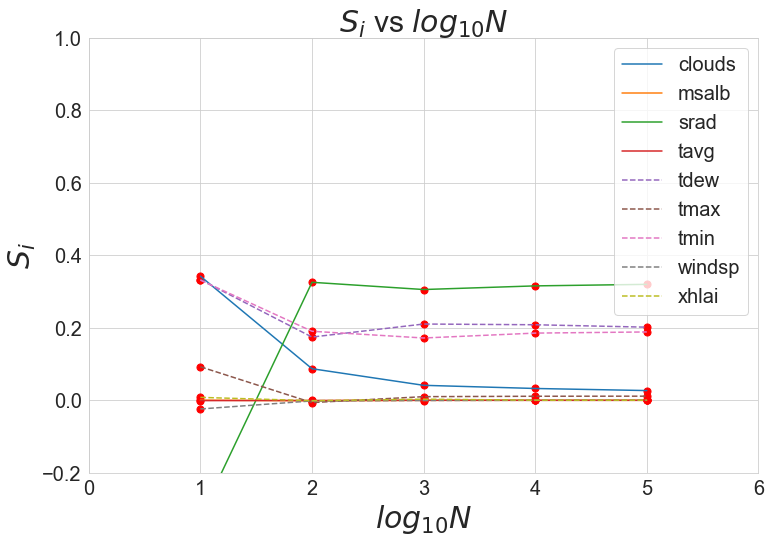

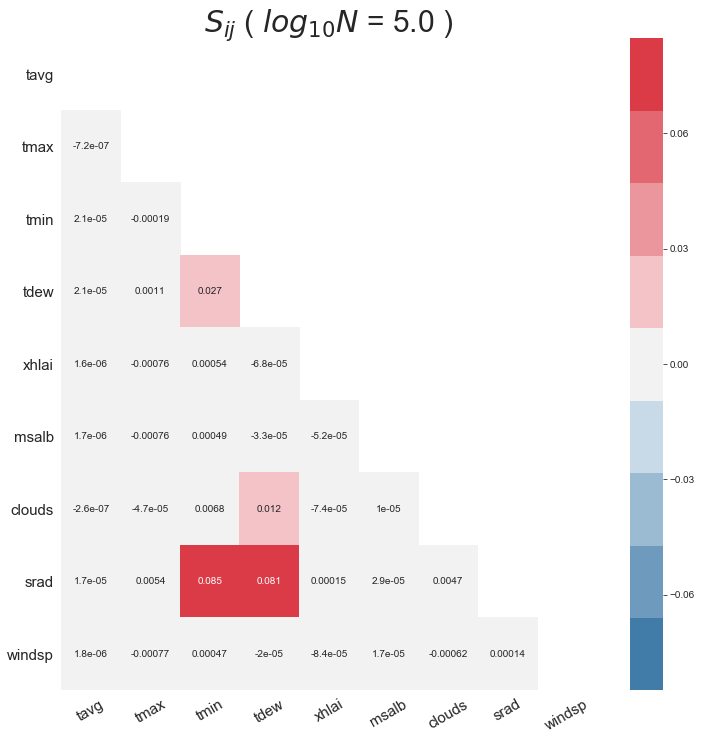

In [50]:
bounds = {
        'tmax':[-10.0, 4.99],
        'tmin':[0.0, 23.9],
        'srad': [2.45, 27.8],
        'msalb': [0.18, 0.2],
        'xhlai': [0.0, 4.77],
        'tavg': [8.0, 31],
        'tdew': [8.0, 31],
        'windsp': [0.0, 10.0],
        'clouds': [0.0, 1.0]
    }

SM = SensitivityModel(model, bounds, sample_list, method)

decimal=4
df_PETPNO_S1_set2, df_PETPNO_ST_set2 = SM.generate_dataframe(decimal=4)

indices_lst = SM.generate_indices()

SM.sensitivity_plots(indices_lst, "S1")
SM.sensitivity_plots(indices_lst, "S2")

### Result Set 3 - TMAX : [35.1,  55.0]

- SRAD has maximum S1 and close to 1.0 signifying that the majority of contribution to sensitivity stems from this parameter 

- CLOUDS, TMAX has moderately strong S1 index

In [ ]:
bounds = {
        'tmax':[35.1, 55.0],
        'tmin':[0.0, 23.9],
        'srad': [2.45, 27.8],
        'msalb': [0.18, 0.2],
        'xhlai': [0.0, 4.77],
        'tavg': [8.0, 31],
        'tdew': [8.0, 31],
        'windsp': [0.0, 10.0],
        'clouds': [0.0, 1.0]
    }

SM = SensitivityModel(model, bounds, sample_list, method)

decimal=4
df_PETPNO_S1_set3, df_PETPNO_ST_set3 = SM.generate_dataframe(decimal)

indices_lst = SM.generate_indices()

SM.sensitivity_plots(indices_lst, "S1")
SM.sensitivity_plots(indices_lst, "S2")

### XHLAI : [-5.0,  5.0] ; TMAX : [5.0,  35.0]

There exists a conditional (shown below) in PETPNO which alters the function of EO. We take negative values of XHLAI to probe whether it affects the analysis. TMAX values have been taken from Result Set 1

- No significant change is observed

``` fortran
      IF (XHLAI .LE. 0.0) THEN
        ALBEDO = MSALB
      ELSE
        ALBEDO = 0.23-(0.23-MSALB)*EXP(-0.75*XHLAI)
      ENDIF

```

In [ ]:
bounds = {
        'tmax':[5.0, 35.0],
        'tmin':[0.0, 23.9],
        'srad': [2.45, 27.8],
        'msalb': [0.18, 0.2],
        'xhlai': [-5.0, 5.0],
        'tavg': [8.0, 31],
        'tdew': [8.0, 31],
        'windsp': [0.0, 10.0],
        'clouds': [0.0, 1.0]
    }

SM = SensitivityModel(model, bounds, sample_list, method)

decimal=4
df_PETPNO_S1_xhlai, df_PETPNO_ST_xhlai = SM.generate_dataframe(decimal)

indices_lst = SM.generate_indices()

SM.sensitivity_plots(indices_lst, "S1")
SM.sensitivity_plots(indices_lst, "S2")

### SRAD : [0.0,  5.0];  TMAX : [5.0,  35.0]

Severely restricting the range of SRAD changes the S1 vs log(N) profile appreciably. This is interesting since the only place SRAD appears in the code is in the assignment of RNET :
```fortran
      RNET= (1.0-ALBEDO)*SRAD - RADB
```

What it simply tells us is that the extent to which SRAD can contribute to the variance in the output depends enormously on its bounds.

*** ALL OUTPUT FILES LIVE IN [.]
*** ALL OUTPUT FILES LIVE IN [.]
*** ALL OUTPUT FILES LIVE IN [.]
*** ALL OUTPUT FILES LIVE IN [.]
*** ALL OUTPUT FILES LIVE IN [.]
*** ALL OUTPUT FILES LIVE IN [.]


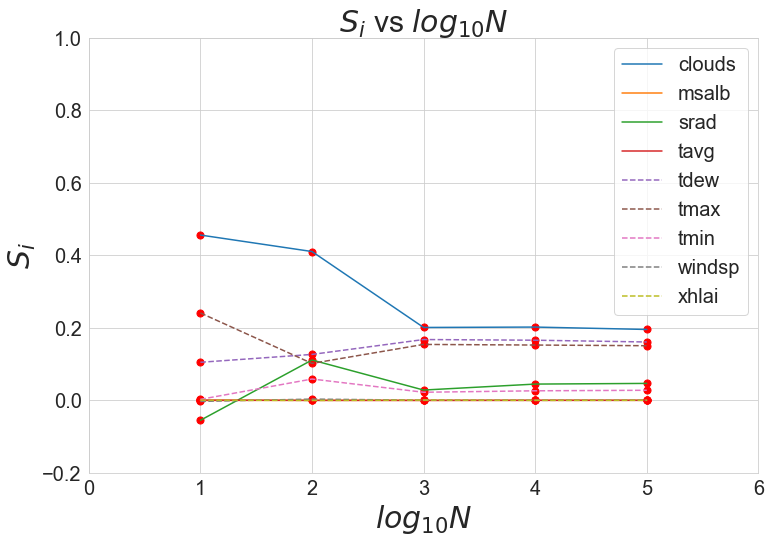

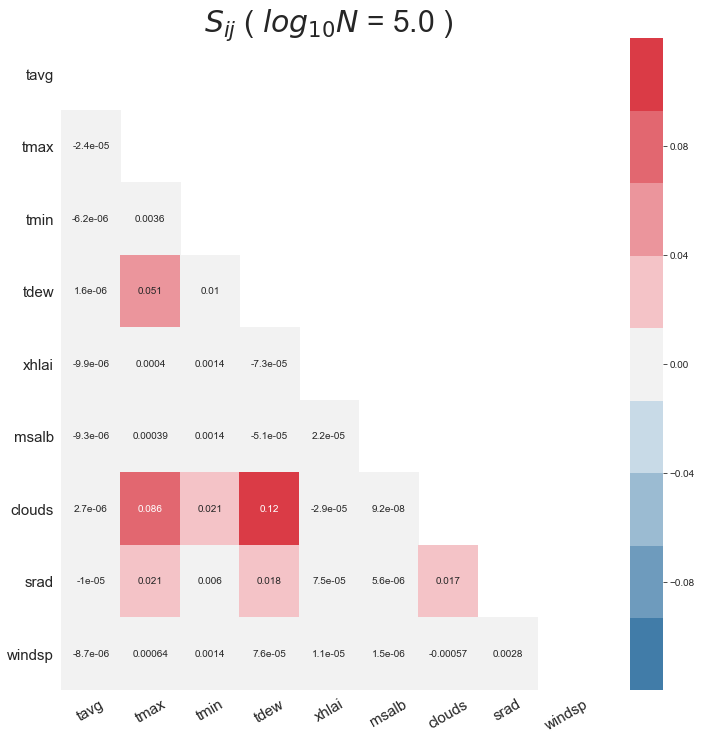

In [57]:
model = 'PETPNO'
bounds = {
        'tmax':[5.0, 35.0],
        'tmin':[0.0, 23.9],
        'srad': [0.0, 5.0],
        'msalb': [0.18, 0.2],
        'xhlai': [0.0, 4.77],
        'tavg': [8.0, 31],
        'tdew': [8.0, 31],
        'windsp': [0.0, 10.0],
        'clouds': [0.0, 1.0]
    }

SM = SensitivityModel(model, bounds, sample_list, method)

decimal=4
df_PETPNO_S1_srad, df_PETPNO_ST_srad = SM.generate_dataframe(decimal)

indices_lst = SM.generate_indices()

SM.sensitivity_plots(indices_lst, "S1")
SM.sensitivity_plots(indices_lst, "S2")

## PETPEN 

### Result Set 1  -  TMAX : [5.0,  35.0}

- SRAD yet again has the highest S1 index
- EORATIO has a large S1 index unqiue to PETPEN
- (VAPR, CLOUDS), (EORATIO, XHLAI), (EORATIO, SRAD) have significant S2 indices 

*** ALL OUTPUT FILES LIVE IN [.]
*** ALL OUTPUT FILES LIVE IN [.]
*** ALL OUTPUT FILES LIVE IN [.]
*** ALL OUTPUT FILES LIVE IN [.]
*** ALL OUTPUT FILES LIVE IN [.]
*** ALL OUTPUT FILES LIVE IN [.]


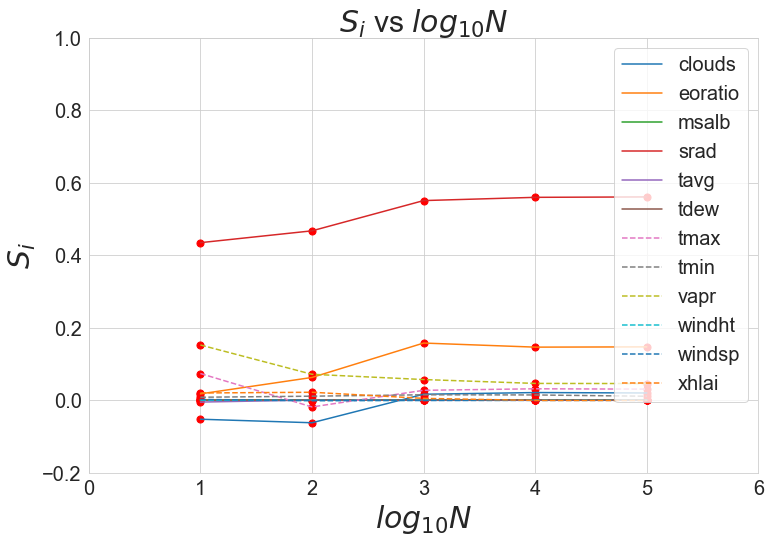

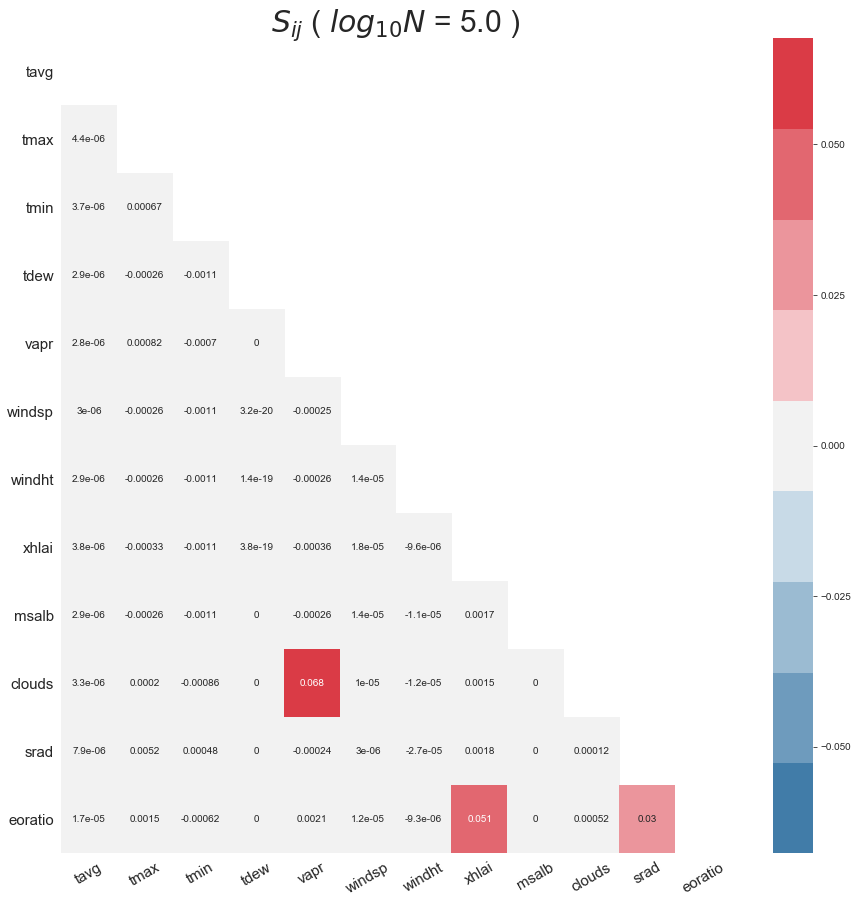

In [95]:
model = 'PETPEN'

bounds = {
        'tmax':[5.0, 35.0],
        'tmin':[0.0, 23.9],
        'srad': [2.45, 27.8],
        'msalb': [0.18, 0.2],
        'xhlai': [0.0, 4.77],
        'tavg': [8.0, 31],
        'tdew': [8.0, 31],
        'windsp': [0.0, 10.0],
        'windht': [1.0, 25.0],
        'vapr': [0.0, 20.0],
        'clouds': [0.0, 1.0],
        'eoratio': [0.0, 2.0]
}



SM = SensitivityModel(model, bounds, sample_list, method)

decimal=4
df_PETPEN_S1_set1, df_PETPEN_ST_set1 = SM.generate_dataframe(decimal)

indices_lst = SM.generate_indices()

SM.sensitivity_plots(indices_lst, "S1")
SM.sensitivity_plots(indices_lst, "S2")

### Result Set 2  -  TMAX : [-10.0,  4.99]

- SRAD still has the highest S1 index
- S2 values of relevant pairs are similar

*** ALL OUTPUT FILES LIVE IN [.]
*** ALL OUTPUT FILES LIVE IN [.]
*** ALL OUTPUT FILES LIVE IN [.]
*** ALL OUTPUT FILES LIVE IN [.]
*** ALL OUTPUT FILES LIVE IN [.]
*** ALL OUTPUT FILES LIVE IN [.]


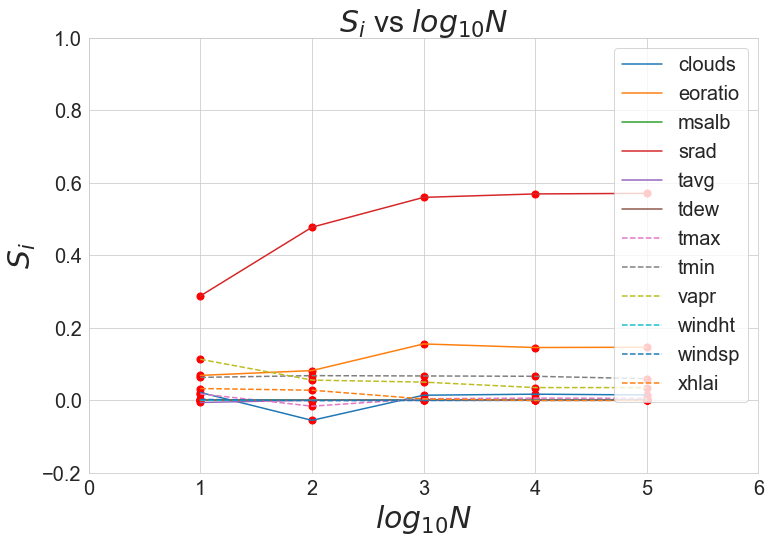

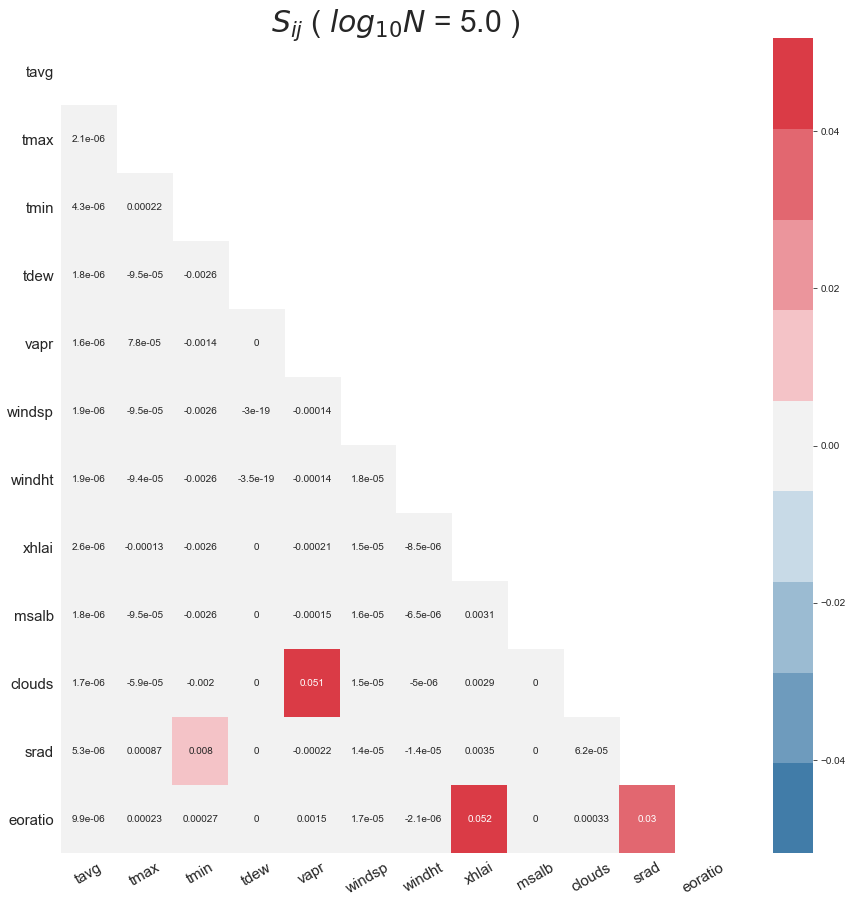

In [49]:
bounds = {
        'tmax':[-10.0, 4.99],
        'tmin':[0.0, 23.9],
        'srad': [2.45, 27.8],
        'msalb': [0.18, 0.2],
        'xhlai': [0.0, 4.77],
        'tavg': [8.0, 31],
        'tdew': [8.0, 31],
        'windsp': [0.0, 10.0],
        'windht': [1.0, 25.0],
        'vapr': [0.0, 20.0],
        'clouds': [0.0, 1.0],
        'eoratio': [0.0, 2.0]
}



SM = SensitivityModel(model, bounds, sample_list, method)

decimal=4
df_PETPEN_S1_set2, df_PETPEN_ST_set2 = SM.generate_dataframe(decimal)

indices_lst = SM.generate_indices()

SM.sensitivity_plots(indices_lst, "S1")
SM.sensitivity_plots(indices_lst, "S2")

### Result Set 3  -  TMAX : [35.1,  55.0]

-  SRAD has the highest S1
- Trend in S2 does not appear to change appreciably

In [ ]:
bounds = {
        'tmax':[35.1, 55.0],
        'tmin':[0.0, 23.9],
        'srad': [2.45, 27.8],
        'msalb': [0.18, 0.2],
        'xhlai': [0.0, 4.77],
        'tavg': [8.0, 31],
        'tdew': [8.0, 31],
        'windsp': [0.0, 10.0],
        'windht': [1.0, 25.0],
        'vapr': [0.0, 20.0],
        'clouds': [0.0, 1.0],
        'eoratio': [0.0, 2.0]
}



SM = SensitivityModel(model, bounds, sample_list, method)

decimal=4
df_PETPEN_S1_set3, df_PETPEN_ST_set3 = SM.generate_dataframe(decimal)

indices_lst = SM.generate_indices()

SM.sensitivity_plots(indices_lst, "S1")
SM.sensitivity_plots(indices_lst, "S2")

### XHLAI : [-5.0,  5.0] ; TMAX : [5.0,  35.0]

We repeat the same trials as was done in previous models where based on conditional statements, we vary the input parameter interval ranges to see if that causes any change in the ranking of the sensitivity indices.

```fortran
      IF (XHLAI .LE. 0.0) THEN
        ALBEDO = MSALB
      ELSE
        ALBEDO = 0.23-(0.23-SALB)*EXP(-0.75*XHLAI)
        ALBEDO = 0.23
      ENDIF
```

In [ ]:
bounds = {
        'tmax':[5.0, 35.0],
        'tmin':[0.0, 23.9],
        'srad': [2.45, 27.8],
        'msalb': [0.18, 0.2],
        'xhlai': [-5.0, 5.0],
        'tavg': [8.0, 31],
        'tdew': [8.0, 31],
        'windsp': [0.0, 10.0],
        'windht': [1.0, 25.0],
        'vapr': [0.0, 20.0],
        'clouds': [0.0, 1.0],
        'eoratio': [0.0, 2.0]
}



SM = SensitivityModel(model, bounds, sample_list, method)

decimal=4
df_PETPEN_S1_xhlai, df_PETPEN_ST_xhlai = SM.generate_dataframe(decimal)

indices_lst = SM.generate_indices()

SM.sensitivity_plots(indices_lst, "S1")
SM.sensitivity_plots(indices_lst, "S2")

### SRAD:  [0.0,  5.0] ; TMAX : [5.0,  35.0]

-  Changing the interval range of SRAD dramatically alters the Sobol index ranking. S1 contribution from SRAD is decreased significantly.

-  Again, if one looks at the PETPEN Fortran code, SRAD appears in the assignment of RNET as seen in PETPNO

```fortran
      RNET= (1.0-ALBEDO)*SRAD - RADB
```

*** ALL OUTPUT FILES LIVE IN [.]
*** ALL OUTPUT FILES LIVE IN [.]
*** ALL OUTPUT FILES LIVE IN [.]
*** ALL OUTPUT FILES LIVE IN [.]
*** ALL OUTPUT FILES LIVE IN [.]
*** ALL OUTPUT FILES LIVE IN [.]


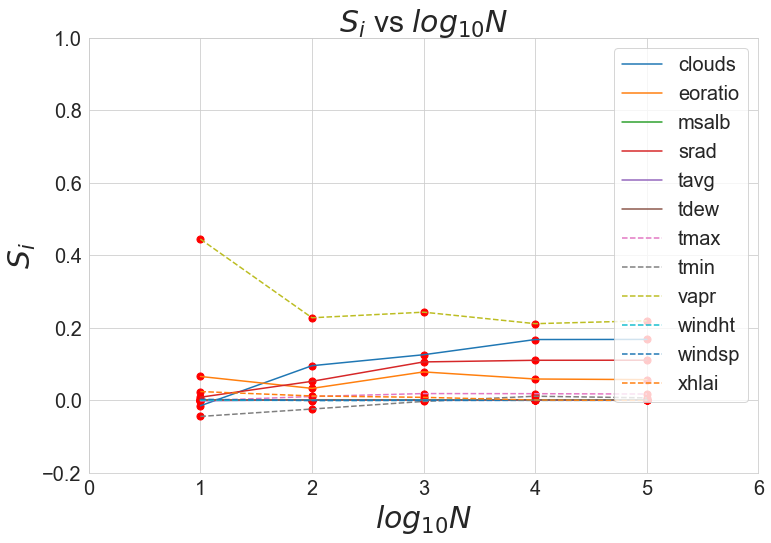

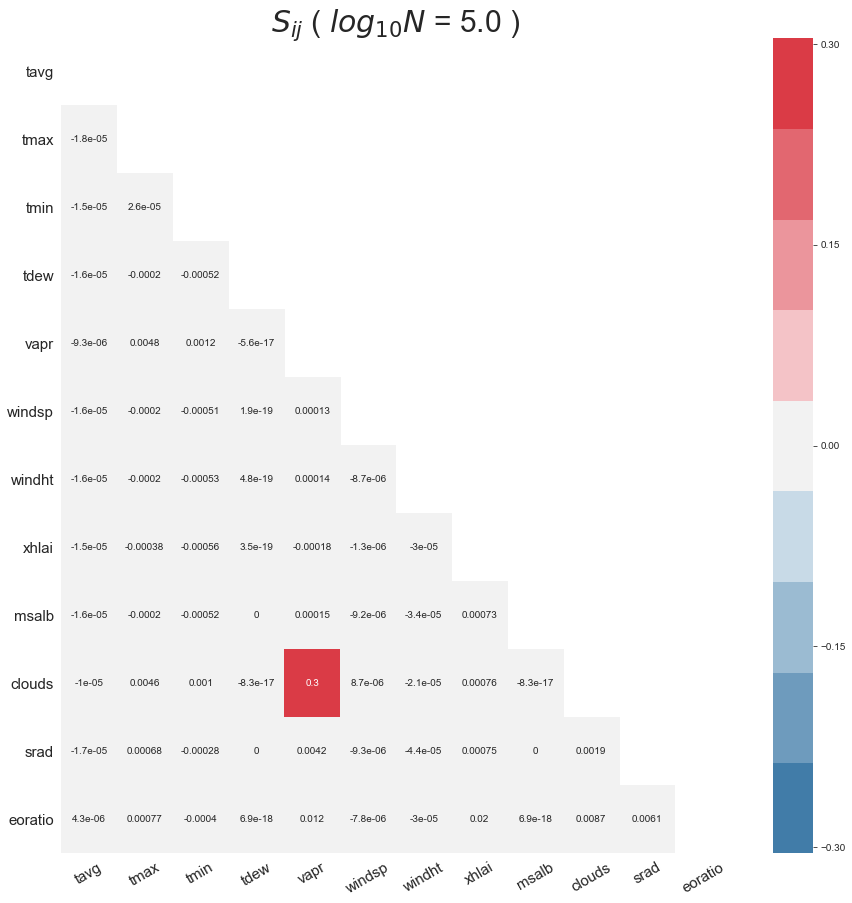

In [56]:
bounds = {
        'tmax':[5.0, 35.0],
        'tmin':[0.0, 23.9],
        'srad': [0.0, 5.0],
        'msalb': [0.18, 0.2],
        'xhlai': [0.0, 4.77],
        'tavg': [8.0, 31],
        'tdew': [8.0, 31],
        'windsp': [0.0, 10.0],
        'windht': [1.0, 25.0],
        'vapr': [0.0, 20.0],
        'clouds': [0.0, 1.0],
        'eoratio': [0.0, 2.0]
}



SM = SensitivityModel(model, bounds, sample_list, method)

decimal=4
df_PETPEN_S1_srad, df_PETPEN_ST_srad = SM.generate_dataframe(decimal)

indices_lst = SM.generate_indices()

SM.sensitivity_plots(indices_lst, "S1")
SM.sensitivity_plots(indices_lst, "S2")

## PETDYN

### Result Set 1 - TMAX : [5.0,  35.0]

-  SRAD has an overwhelming contribution to the overall variance
- All other sobol indices are relatively insignificant in comparison to SRAD 

*** ALL OUTPUT FILES LIVE IN [.]
*** ALL OUTPUT FILES LIVE IN [.]
*** ALL OUTPUT FILES LIVE IN [.]
*** ALL OUTPUT FILES LIVE IN [.]
*** ALL OUTPUT FILES LIVE IN [.]
*** ALL OUTPUT FILES LIVE IN [.]


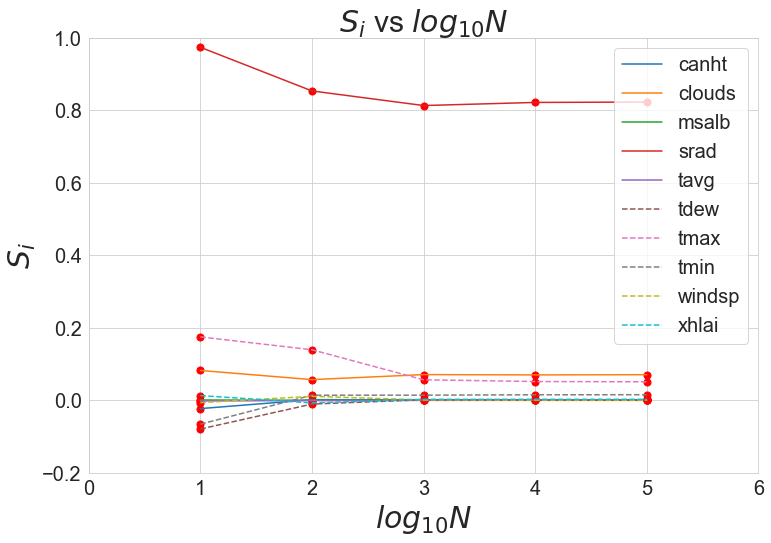

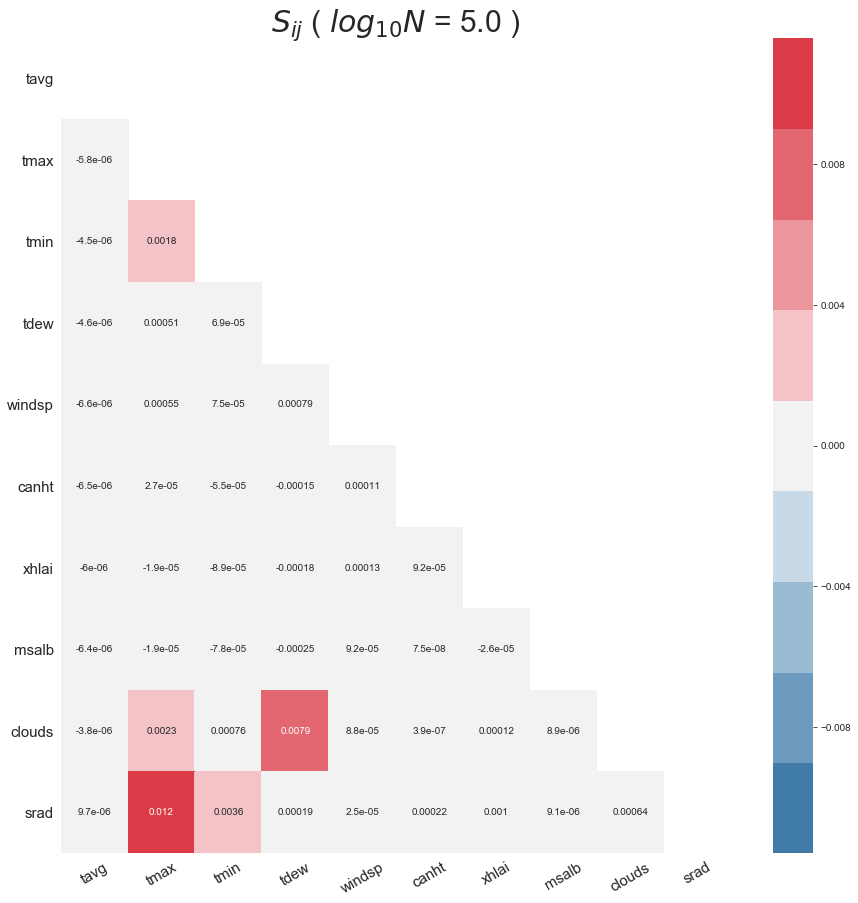

In [96]:
model = 'PETDYN'

bounds = {
        'tmax':[5.0, 35.0],
        'tmin':[0.0, 23.9],
        'srad': [2.45, 27.8],
        'msalb': [0.18, 0.2],
        'xhlai': [0.0, 4.77],
        'tavg': [8.0, 31],
        'tdew': [8.0, 31],
        'windsp': [0.0, 10.0],
        'clouds': [0.0, 1.0],
        'canht': [0.0, 5.0]
}

SM = SensitivityModel(model, bounds, sample_list, method)

decimal=4
df_PETDYN_S1_set1, df_PETDYN_ST_set1 = SM.generate_dataframe(decimal)

indices_lst = SM.generate_indices()

SM.sensitivity_plots(indices_lst, "S1")
SM.sensitivity_plots(indices_lst, "S2")

### Result Set 2 - TMAX : [-10.0,  4.99]

- Even with a different range of TMAX, S1 from SRAD is the largest. 

*** ALL OUTPUT FILES LIVE IN [.]
*** ALL OUTPUT FILES LIVE IN [.]
*** ALL OUTPUT FILES LIVE IN [.]
*** ALL OUTPUT FILES LIVE IN [.]
*** ALL OUTPUT FILES LIVE IN [.]
*** ALL OUTPUT FILES LIVE IN [.]


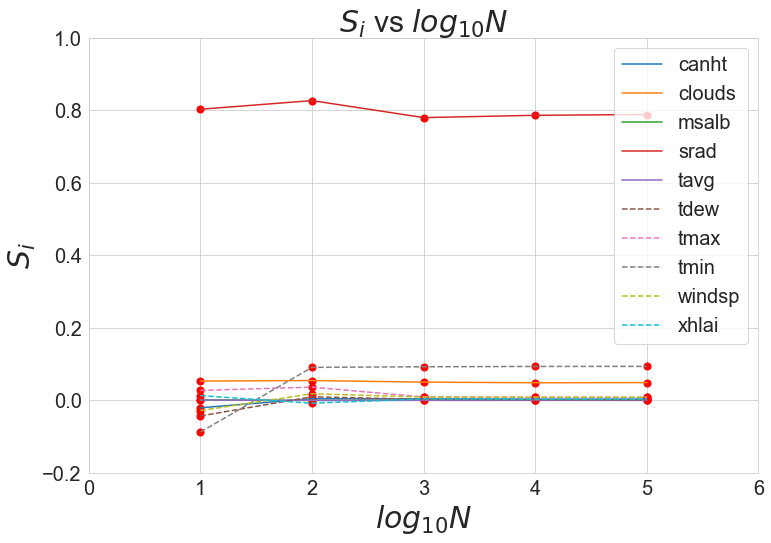

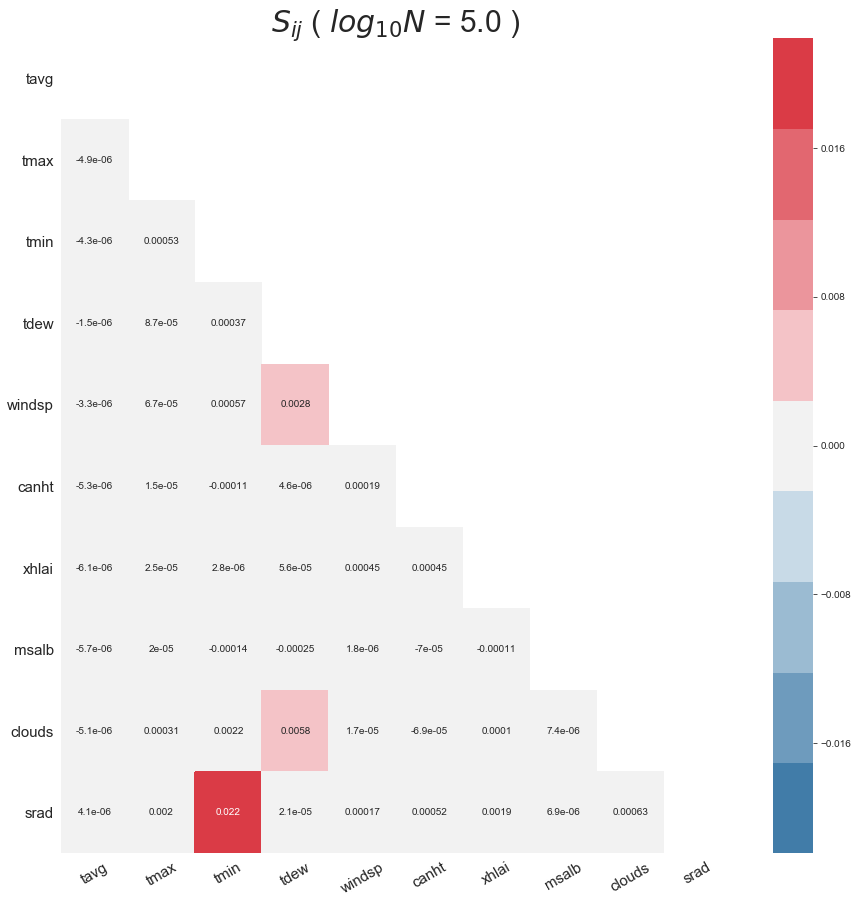

In [48]:
bounds = {
        'tmax':[-10.0, 4.99],
        'tmin':[0.0, 23.9],
        'srad': [2.45, 27.8],
        'msalb': [0.18, 0.2],
        'xhlai': [0.0, 4.77],
        'tavg': [8.0, 31],
        'tdew': [8.0, 31],
        'windsp': [0.0, 10.0],
        'clouds': [0.0, 1.0],
        'canht': [0.0, 5.0]
}

SM = SensitivityModel(model, bounds, sample_list, method)

decimal=4
df_PETDYN_S1_set2, df_PETDYN_ST_set2 = SM.generate_dataframe(decimal)

indices_lst = SM.generate_indices()

SM.sensitivity_plots(indices_lst, "S1")
SM.sensitivity_plots(indices_lst, "S2")

### Result Set 3 - TMAX : [35.1,  55.0]

- Across all ranges of TMAX, SRAD has the highest S1

In [ ]:
bounds = {
        'tmax':[35.1, 55.0],
        'tmin':[0.0, 23.9],
        'srad': [2.45, 27.8],
        'msalb': [0.18, 0.2],
        'xhlai': [0.0, 4.77],
        'tavg': [8.0, 31],
        'tdew': [8.0, 31],
        'windsp': [0.0, 10.0],
        'clouds': [0.0, 1.0],
        'canht': [0.0, 5.0]
}

SM = SensitivityModel(model, bounds, sample_list, method)

decimal=4
df_PETDYN_S1_set3, df_PETDYN_ST_set3 = SM.generate_dataframe(decimal)

indices_lst = SM.generate_indices()

SM.sensitivity_plots(indices_lst, "S1")
SM.sensitivity_plots(indices_lst, "S2")

### SRAD : [0.0,  5.0] ; TMAX : [5.0,  35.0]

- Severely constraining/restricting the interval range of SRAD, changes the S1 values of the parameters.
- Most notably, SRAD S1 is lowered well below its previous values. S1 due to CLOUDS begin to dominate with the largest S1 index.
- In the S2 matrix, (CLOUDS, SRAD) and (CLOUDS, TDEW) yield moderately large S2 values.

*** ALL OUTPUT FILES LIVE IN [.]
*** ALL OUTPUT FILES LIVE IN [.]
*** ALL OUTPUT FILES LIVE IN [.]
*** ALL OUTPUT FILES LIVE IN [.]
*** ALL OUTPUT FILES LIVE IN [.]
*** ALL OUTPUT FILES LIVE IN [.]


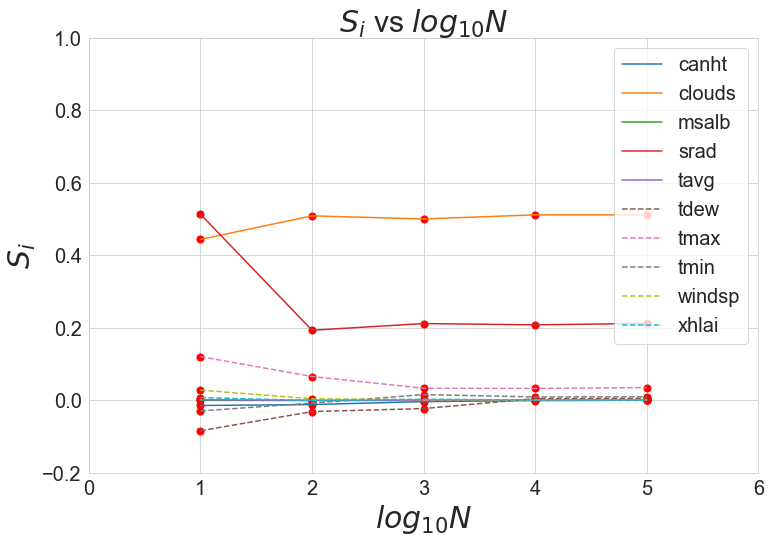

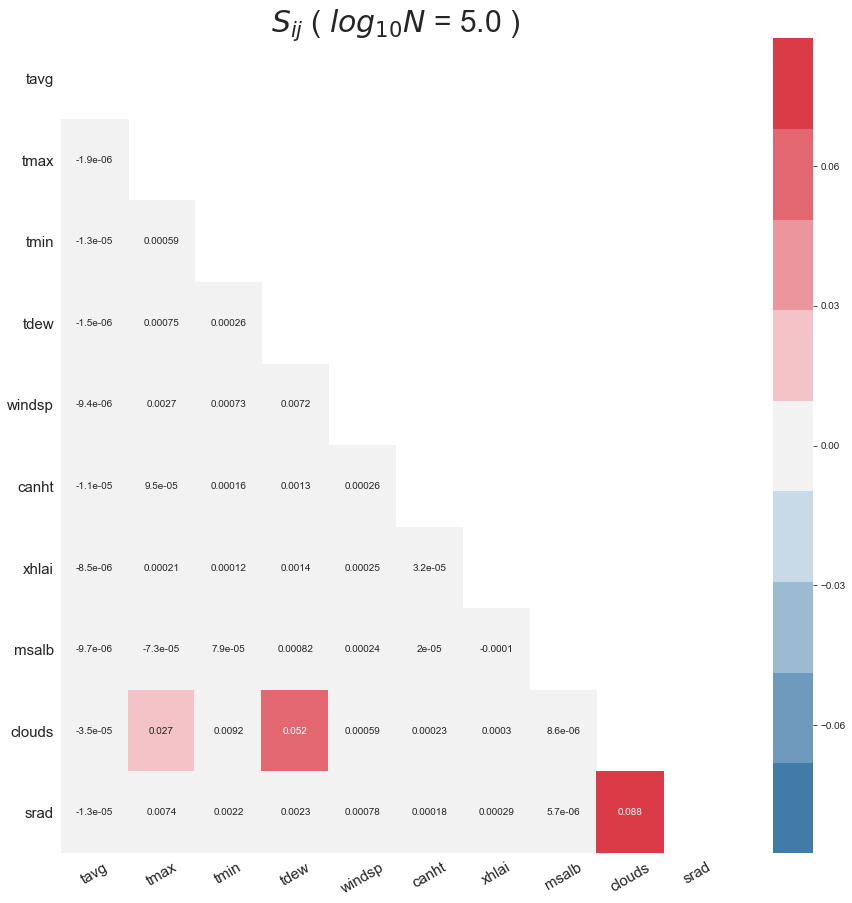

In [79]:
bounds = {
        'tmax':[5.0, 35.0],
        'tmin':[0.0, 23.9],
        'srad': [0.0, 5.0],
        'msalb': [0.18, 0.2],
        'xhlai': [0.0, 4.77],
        'tavg': [8.0, 31],
        'tdew': [8.0, 31],
        'windsp': [0.0, 10.0],
        'clouds': [0.0, 1.0],
        'canht': [0.0, 5.0]
}

SM = SensitivityModel(model, bounds, sample_list, method)

decimal=4
df_PETDYN_S1_srad, df_PETDYN_ST_srad = SM.generate_dataframe(decimal)

indices_lst = SM.generate_indices()

SM.sensitivity_plots(indices_lst, "S1")
SM.sensitivity_plots(indices_lst, "S2")

## PETASCE

### Result Set 1 - TMAX : [5.0,  35.0]

-  SRAD has the largest S1 index
-  In a slight departure from what has been observed up until now, XHLAI has a fairly contribution to the response variance.
- The interaction of SRAD and XHLAI yields an S2 index above the threshol of. 0.01.

*** ALL OUTPUT FILES LIVE IN [.]


/Users/souratoshkhan/automates/notebooks/PETASCE_simple_lambdas.py:122: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return (meevp == "A")
/Users/souratoshkhan/automates/notebooks/PETASCE_simple_lambdas.py:191: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return (meevp == "A")
/Users/souratoshkhan/automates/notebooks/PETASCE_simple_lambdas.py:137: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return (meevp == "G")
/Users/souratoshkhan/automates/notebooks/PETASCE_simple_lambdas.py:200: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return (meevp == "G")


*** ALL OUTPUT FILES LIVE IN [.]


/Users/souratoshkhan/automates/notebooks/PETASCE_simple_lambdas.py:122: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return (meevp == "A")
/Users/souratoshkhan/automates/notebooks/PETASCE_simple_lambdas.py:191: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return (meevp == "A")
/Users/souratoshkhan/automates/notebooks/PETASCE_simple_lambdas.py:137: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return (meevp == "G")
/Users/souratoshkhan/automates/notebooks/PETASCE_simple_lambdas.py:200: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return (meevp == "G")


*** ALL OUTPUT FILES LIVE IN [.]


/Users/souratoshkhan/automates/notebooks/PETASCE_simple_lambdas.py:122: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return (meevp == "A")
/Users/souratoshkhan/automates/notebooks/PETASCE_simple_lambdas.py:191: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return (meevp == "A")
/Users/souratoshkhan/automates/notebooks/PETASCE_simple_lambdas.py:137: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return (meevp == "G")
/Users/souratoshkhan/automates/notebooks/PETASCE_simple_lambdas.py:200: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return (meevp == "G")


*** ALL OUTPUT FILES LIVE IN [.]


/Users/souratoshkhan/automates/notebooks/PETASCE_simple_lambdas.py:122: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return (meevp == "A")
/Users/souratoshkhan/automates/notebooks/PETASCE_simple_lambdas.py:191: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return (meevp == "A")
/Users/souratoshkhan/automates/notebooks/PETASCE_simple_lambdas.py:137: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return (meevp == "G")
/Users/souratoshkhan/automates/notebooks/PETASCE_simple_lambdas.py:200: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return (meevp == "G")


*** ALL OUTPUT FILES LIVE IN [.]


/Users/souratoshkhan/automates/notebooks/PETASCE_simple_lambdas.py:122: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return (meevp == "A")
/Users/souratoshkhan/automates/notebooks/PETASCE_simple_lambdas.py:191: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return (meevp == "A")
/Users/souratoshkhan/automates/notebooks/PETASCE_simple_lambdas.py:137: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return (meevp == "G")
/Users/souratoshkhan/automates/notebooks/PETASCE_simple_lambdas.py:200: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return (meevp == "G")


*** ALL OUTPUT FILES LIVE IN [.]


/Users/souratoshkhan/automates/notebooks/PETASCE_simple_lambdas.py:122: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return (meevp == "A")
/Users/souratoshkhan/automates/notebooks/PETASCE_simple_lambdas.py:191: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return (meevp == "A")
/Users/souratoshkhan/automates/notebooks/PETASCE_simple_lambdas.py:137: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return (meevp == "G")
/Users/souratoshkhan/automates/notebooks/PETASCE_simple_lambdas.py:200: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return (meevp == "G")


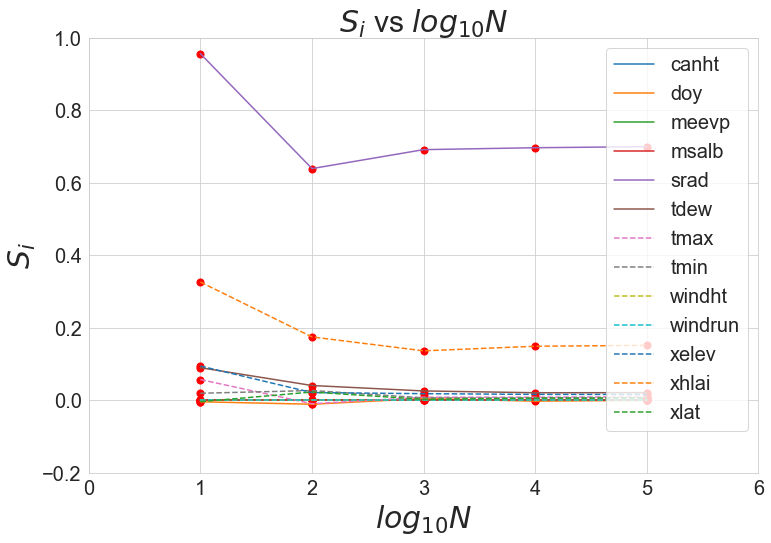

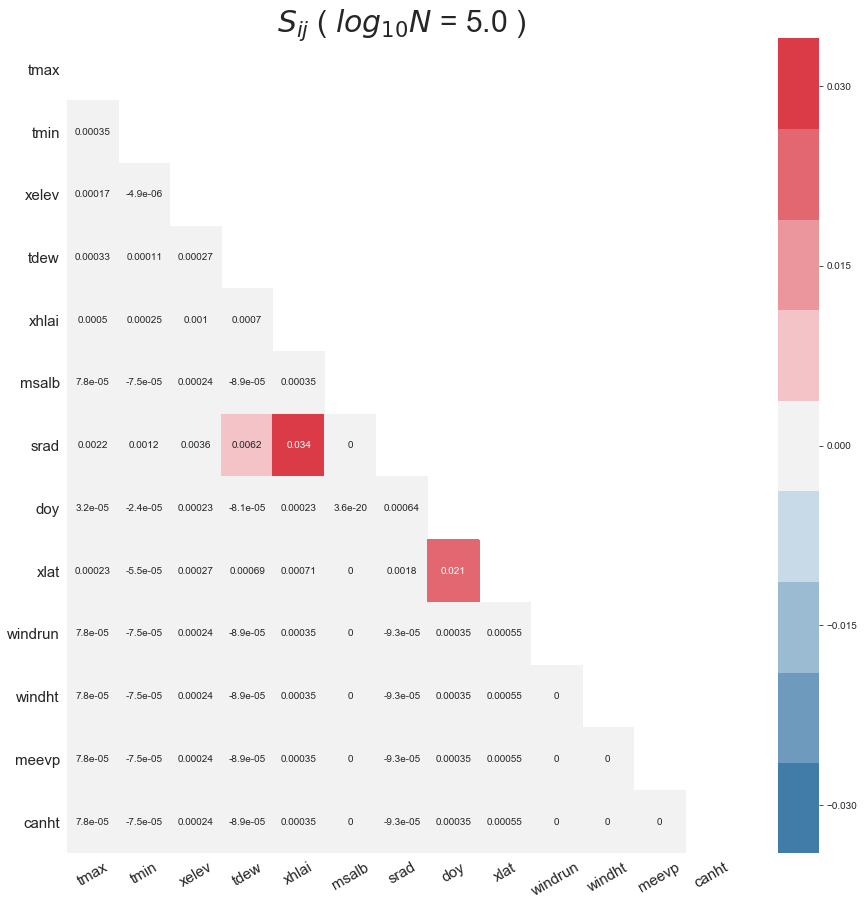

In [86]:
model = 'PETASCE'

bounds = {
        'tmax':[5.0, 35.0],
        'tmin':[0.0, 23.9],
        'srad': [2.45, 27.8],
        'msalb': [0.18, 0.2],
        'xhlai': [0.0, 4.77],
        'tdew': [8.0, 31],
        'windht': [1.0, 25.0],
        'windrun': [0, 900],
        'xlat': [-65.0, 65.0],
        'xelev': [0, 6000],
        'canht': [0.0, 5.0],
        'doy': [1, 365],
        'meevp': [0, 1],
}


SM = SensitivityModel(model, bounds, sample_list, method)

decimal=4
df_PETASCE_S1_set1, df_PETASCE_ST_set1 = SM.generate_dataframe(decimal)

indices_lst = SM.generate_indices()

SM.sensitivity_plots(indices_lst, "S1")
SM.sensitivity_plots(indices_lst, "S2")

### Result Set 2 - TMAX : [-10.0,  4.99]

- SRAD followed by XHLAI still have the highest S1 indices while (SRAD, XHLAI) pair has the largest S2 index.

*** ALL OUTPUT FILES LIVE IN [.]


/Users/souratoshkhan/automates/notebooks/PETASCE_simple_lambdas.py:122: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return (meevp == "A")
/Users/souratoshkhan/automates/notebooks/PETASCE_simple_lambdas.py:191: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return (meevp == "A")
/Users/souratoshkhan/automates/notebooks/PETASCE_simple_lambdas.py:137: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return (meevp == "G")
/Users/souratoshkhan/automates/notebooks/PETASCE_simple_lambdas.py:200: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return (meevp == "G")


*** ALL OUTPUT FILES LIVE IN [.]


/Users/souratoshkhan/automates/notebooks/PETASCE_simple_lambdas.py:122: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return (meevp == "A")
/Users/souratoshkhan/automates/notebooks/PETASCE_simple_lambdas.py:191: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return (meevp == "A")
/Users/souratoshkhan/automates/notebooks/PETASCE_simple_lambdas.py:137: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return (meevp == "G")
/Users/souratoshkhan/automates/notebooks/PETASCE_simple_lambdas.py:200: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return (meevp == "G")


*** ALL OUTPUT FILES LIVE IN [.]


/Users/souratoshkhan/automates/notebooks/PETASCE_simple_lambdas.py:122: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return (meevp == "A")
/Users/souratoshkhan/automates/notebooks/PETASCE_simple_lambdas.py:191: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return (meevp == "A")
/Users/souratoshkhan/automates/notebooks/PETASCE_simple_lambdas.py:137: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return (meevp == "G")
/Users/souratoshkhan/automates/notebooks/PETASCE_simple_lambdas.py:200: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return (meevp == "G")


*** ALL OUTPUT FILES LIVE IN [.]


/Users/souratoshkhan/automates/notebooks/PETASCE_simple_lambdas.py:122: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return (meevp == "A")
/Users/souratoshkhan/automates/notebooks/PETASCE_simple_lambdas.py:191: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return (meevp == "A")
/Users/souratoshkhan/automates/notebooks/PETASCE_simple_lambdas.py:137: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return (meevp == "G")
/Users/souratoshkhan/automates/notebooks/PETASCE_simple_lambdas.py:200: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return (meevp == "G")


*** ALL OUTPUT FILES LIVE IN [.]


/Users/souratoshkhan/automates/notebooks/PETASCE_simple_lambdas.py:122: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return (meevp == "A")
/Users/souratoshkhan/automates/notebooks/PETASCE_simple_lambdas.py:191: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return (meevp == "A")
/Users/souratoshkhan/automates/notebooks/PETASCE_simple_lambdas.py:137: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return (meevp == "G")
/Users/souratoshkhan/automates/notebooks/PETASCE_simple_lambdas.py:200: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return (meevp == "G")


*** ALL OUTPUT FILES LIVE IN [.]


/Users/souratoshkhan/automates/notebooks/PETASCE_simple_lambdas.py:122: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return (meevp == "A")
/Users/souratoshkhan/automates/notebooks/PETASCE_simple_lambdas.py:191: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return (meevp == "A")
/Users/souratoshkhan/automates/notebooks/PETASCE_simple_lambdas.py:137: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return (meevp == "G")
/Users/souratoshkhan/automates/notebooks/PETASCE_simple_lambdas.py:200: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return (meevp == "G")


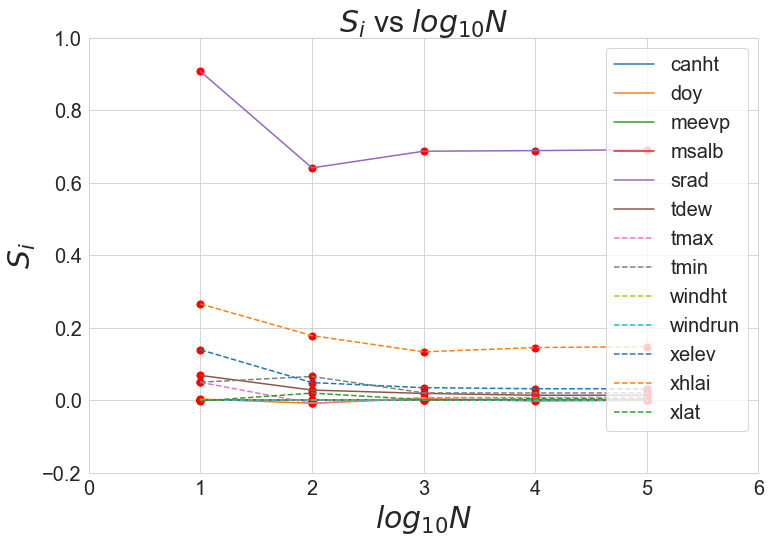

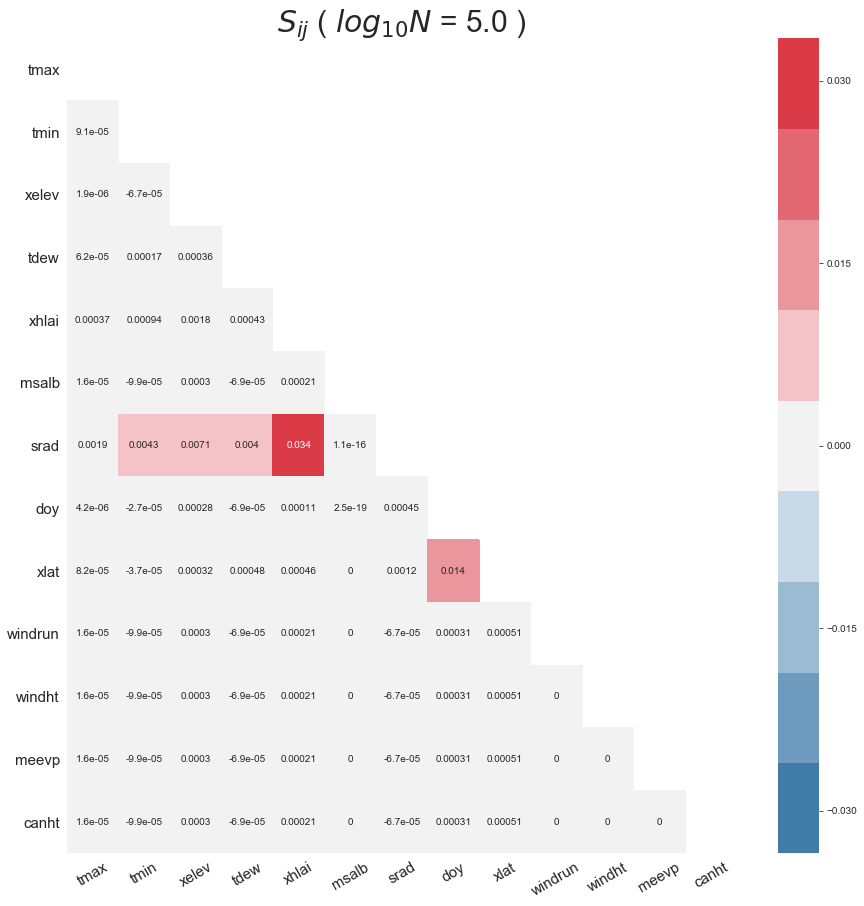

In [88]:
bounds = {
        'tmax':[-10.0, 4.99],
        'tmin':[0.0, 23.9],
        'srad': [2.45, 27.8],
        'msalb': [0.18, 0.2],
        'xhlai': [0.0, 4.77],
        'tdew': [8.0, 31],
        'windht': [1.0, 25.0],
        'windrun': [0, 900],
        'xlat': [-65.0, 65.0],
        'xelev': [0, 6000],
        'canht': [0.0, 5.0],
        'doy': [1, 365],
        'meevp': [0, 1],
}


SM = SensitivityModel(model, bounds, sample_list, method)

decimal=4
df_PETASCE_S1_set2, df_PETASCE_ST_set2 = SM.generate_dataframe(decimal)

indices_lst = SM.generate_indices()

SM.sensitivity_plots(indices_lst, "S1")
SM.sensitivity_plots(indices_lst, "S2")

### Result Set 3 -  TMAX : [35.1,  55.0]

*** ALL OUTPUT FILES LIVE IN [.]


/Users/souratoshkhan/automates/notebooks/PETASCE_simple_lambdas.py:122: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return (meevp == "A")
/Users/souratoshkhan/automates/notebooks/PETASCE_simple_lambdas.py:191: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return (meevp == "A")
/Users/souratoshkhan/automates/notebooks/PETASCE_simple_lambdas.py:137: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return (meevp == "G")
/Users/souratoshkhan/automates/notebooks/PETASCE_simple_lambdas.py:200: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return (meevp == "G")


*** ALL OUTPUT FILES LIVE IN [.]


/Users/souratoshkhan/automates/notebooks/PETASCE_simple_lambdas.py:122: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return (meevp == "A")
/Users/souratoshkhan/automates/notebooks/PETASCE_simple_lambdas.py:191: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return (meevp == "A")
/Users/souratoshkhan/automates/notebooks/PETASCE_simple_lambdas.py:137: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return (meevp == "G")
/Users/souratoshkhan/automates/notebooks/PETASCE_simple_lambdas.py:200: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return (meevp == "G")


*** ALL OUTPUT FILES LIVE IN [.]


/Users/souratoshkhan/automates/notebooks/PETASCE_simple_lambdas.py:122: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return (meevp == "A")
/Users/souratoshkhan/automates/notebooks/PETASCE_simple_lambdas.py:191: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return (meevp == "A")
/Users/souratoshkhan/automates/notebooks/PETASCE_simple_lambdas.py:137: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return (meevp == "G")
/Users/souratoshkhan/automates/notebooks/PETASCE_simple_lambdas.py:200: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return (meevp == "G")


*** ALL OUTPUT FILES LIVE IN [.]


/Users/souratoshkhan/automates/notebooks/PETASCE_simple_lambdas.py:122: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return (meevp == "A")
/Users/souratoshkhan/automates/notebooks/PETASCE_simple_lambdas.py:191: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return (meevp == "A")
/Users/souratoshkhan/automates/notebooks/PETASCE_simple_lambdas.py:137: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return (meevp == "G")
/Users/souratoshkhan/automates/notebooks/PETASCE_simple_lambdas.py:200: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return (meevp == "G")


*** ALL OUTPUT FILES LIVE IN [.]


/Users/souratoshkhan/automates/notebooks/PETASCE_simple_lambdas.py:122: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return (meevp == "A")
/Users/souratoshkhan/automates/notebooks/PETASCE_simple_lambdas.py:191: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return (meevp == "A")
/Users/souratoshkhan/automates/notebooks/PETASCE_simple_lambdas.py:137: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return (meevp == "G")
/Users/souratoshkhan/automates/notebooks/PETASCE_simple_lambdas.py:200: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return (meevp == "G")


*** ALL OUTPUT FILES LIVE IN [.]


/Users/souratoshkhan/automates/notebooks/PETASCE_simple_lambdas.py:122: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return (meevp == "A")
/Users/souratoshkhan/automates/notebooks/PETASCE_simple_lambdas.py:191: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return (meevp == "A")
/Users/souratoshkhan/automates/notebooks/PETASCE_simple_lambdas.py:137: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return (meevp == "G")
/Users/souratoshkhan/automates/notebooks/PETASCE_simple_lambdas.py:200: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return (meevp == "G")


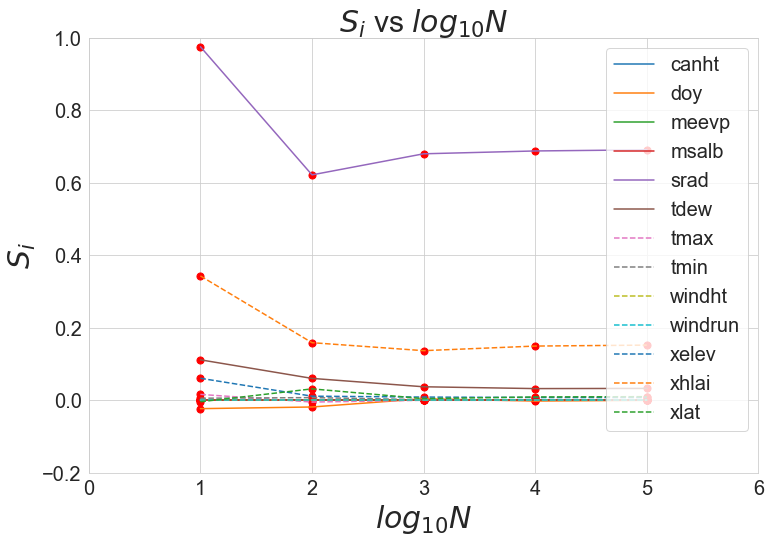

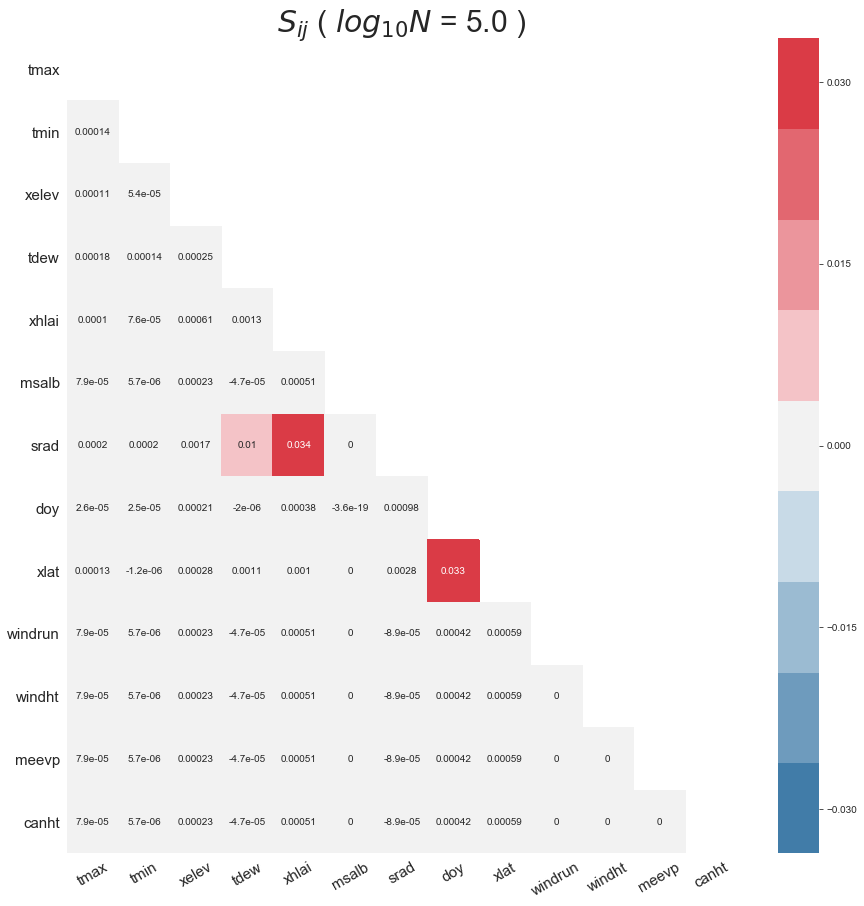

In [89]:
bounds = {
        'tmax':[35.1, 55.0],
        'tmin':[0.0, 23.9],
        'srad': [2.45, 27.8],
        'msalb': [0.18, 0.2],
        'xhlai': [0.0, 4.77],
        'tdew': [8.0, 31],
        'windht': [1.0, 25.0],
        'windrun': [0, 900],
        'xlat': [-65.0, 65.0],
        'xelev': [0, 6000],
        'canht': [0.0, 5.0],
        'doy': [1, 365],
        'meevp': [0, 1],
}


SM = SensitivityModel(model, bounds, sample_list, method)

decimal=4
df_PETASCE_S1_set3, df_PETASCE_ST_set3 = SM.generate_dataframe(decimal)

indices_lst = SM.generate_indices()

SM.sensitivity_plots(indices_lst, "S1")
SM.sensitivity_plots(indices_lst, "S2")

### XHLAI : [-5.0,  5.0]; TMAX : [5.0,   35.0]

Varying the lower bound of XHLAI produces interesting results. We should expect slight changes in the values of indices since it has already been established that XHLAI is an important factor while determining output variance. Static code analysis reveals that condiitonal statements within the code involves XHLAI in two different places as shown below :

```fortran
      IF (XHLAI .LE. 0.0) THEN
        ALBEDO = MSALB
      ELSE
        ALBEDO = 0.23
      ENDIF
      RNS = (1.0-ALBEDO)*SRAD !MJ/m2/d
```

```fortran
      IF (XHLAI .LE. 0.0) THEN
         KCB = 0.0
      ELSE
         !DeJonge et al. (2012) equation
         KCB = MAX(0.0,KCBMIN+(KCBMAX-KCBMIN)*(1.0-EXP(-1.0*SKC*XHLAI)))
      ENDIF
```

These dependencies affect the outcome while computing Sobol indices.

- XHLAI index is raised significantly while S1 of SRAD is lowered simultaneously in this regime. However, SRAD's index is still higher than that of XHLAI as was seen in Penman-Monteith models.

*** ALL OUTPUT FILES LIVE IN [.]


/Users/souratoshkhan/automates/notebooks/PETASCE_simple_lambdas.py:122: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return (meevp == "A")
/Users/souratoshkhan/automates/notebooks/PETASCE_simple_lambdas.py:191: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return (meevp == "A")
/Users/souratoshkhan/automates/notebooks/PETASCE_simple_lambdas.py:137: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return (meevp == "G")
/Users/souratoshkhan/automates/notebooks/PETASCE_simple_lambdas.py:200: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return (meevp == "G")
/Users/souratoshkhan/automates/notebooks/PETASCE_simple_lambdas.py:215: RuntimeWarning: invalid value encountere

*** ALL OUTPUT FILES LIVE IN [.]


/Users/souratoshkhan/automates/notebooks/PETASCE_simple_lambdas.py:122: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return (meevp == "A")
/Users/souratoshkhan/automates/notebooks/PETASCE_simple_lambdas.py:191: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return (meevp == "A")
/Users/souratoshkhan/automates/notebooks/PETASCE_simple_lambdas.py:137: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return (meevp == "G")
/Users/souratoshkhan/automates/notebooks/PETASCE_simple_lambdas.py:200: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return (meevp == "G")
/Users/souratoshkhan/automates/notebooks/PETASCE_simple_lambdas.py:215: RuntimeWarning: invalid value encountere

*** ALL OUTPUT FILES LIVE IN [.]


/Users/souratoshkhan/automates/notebooks/PETASCE_simple_lambdas.py:122: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return (meevp == "A")
/Users/souratoshkhan/automates/notebooks/PETASCE_simple_lambdas.py:191: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return (meevp == "A")
/Users/souratoshkhan/automates/notebooks/PETASCE_simple_lambdas.py:137: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return (meevp == "G")
/Users/souratoshkhan/automates/notebooks/PETASCE_simple_lambdas.py:200: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return (meevp == "G")
/Users/souratoshkhan/automates/notebooks/PETASCE_simple_lambdas.py:215: RuntimeWarning: invalid value encountere

*** ALL OUTPUT FILES LIVE IN [.]


/Users/souratoshkhan/automates/notebooks/PETASCE_simple_lambdas.py:122: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return (meevp == "A")
/Users/souratoshkhan/automates/notebooks/PETASCE_simple_lambdas.py:191: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return (meevp == "A")
/Users/souratoshkhan/automates/notebooks/PETASCE_simple_lambdas.py:137: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return (meevp == "G")
/Users/souratoshkhan/automates/notebooks/PETASCE_simple_lambdas.py:200: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return (meevp == "G")
/Users/souratoshkhan/automates/notebooks/PETASCE_simple_lambdas.py:215: RuntimeWarning: invalid value encountere

*** ALL OUTPUT FILES LIVE IN [.]


/Users/souratoshkhan/automates/notebooks/PETASCE_simple_lambdas.py:122: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return (meevp == "A")
/Users/souratoshkhan/automates/notebooks/PETASCE_simple_lambdas.py:191: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return (meevp == "A")
/Users/souratoshkhan/automates/notebooks/PETASCE_simple_lambdas.py:137: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return (meevp == "G")
/Users/souratoshkhan/automates/notebooks/PETASCE_simple_lambdas.py:200: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return (meevp == "G")
/Users/souratoshkhan/automates/notebooks/PETASCE_simple_lambdas.py:215: RuntimeWarning: invalid value encountere

*** ALL OUTPUT FILES LIVE IN [.]


/Users/souratoshkhan/automates/notebooks/PETASCE_simple_lambdas.py:122: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return (meevp == "A")
/Users/souratoshkhan/automates/notebooks/PETASCE_simple_lambdas.py:191: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return (meevp == "A")
/Users/souratoshkhan/automates/notebooks/PETASCE_simple_lambdas.py:137: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return (meevp == "G")
/Users/souratoshkhan/automates/notebooks/PETASCE_simple_lambdas.py:200: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return (meevp == "G")
/Users/souratoshkhan/automates/notebooks/PETASCE_simple_lambdas.py:215: RuntimeWarning: invalid value encountere

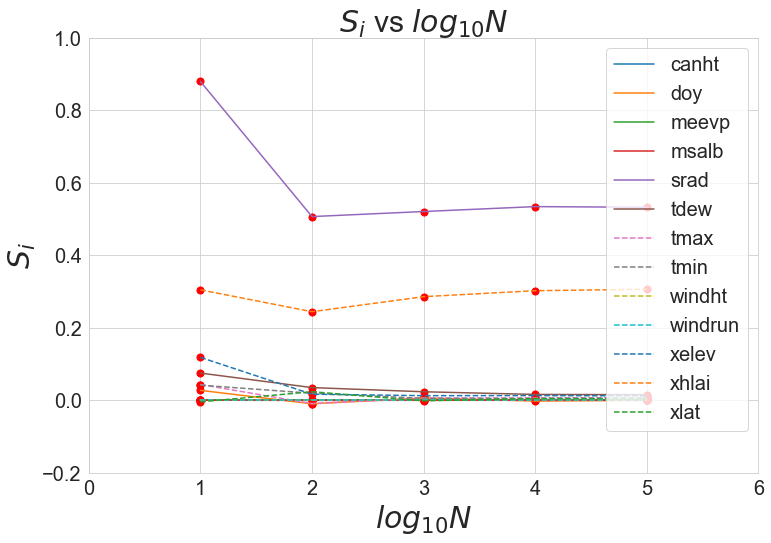

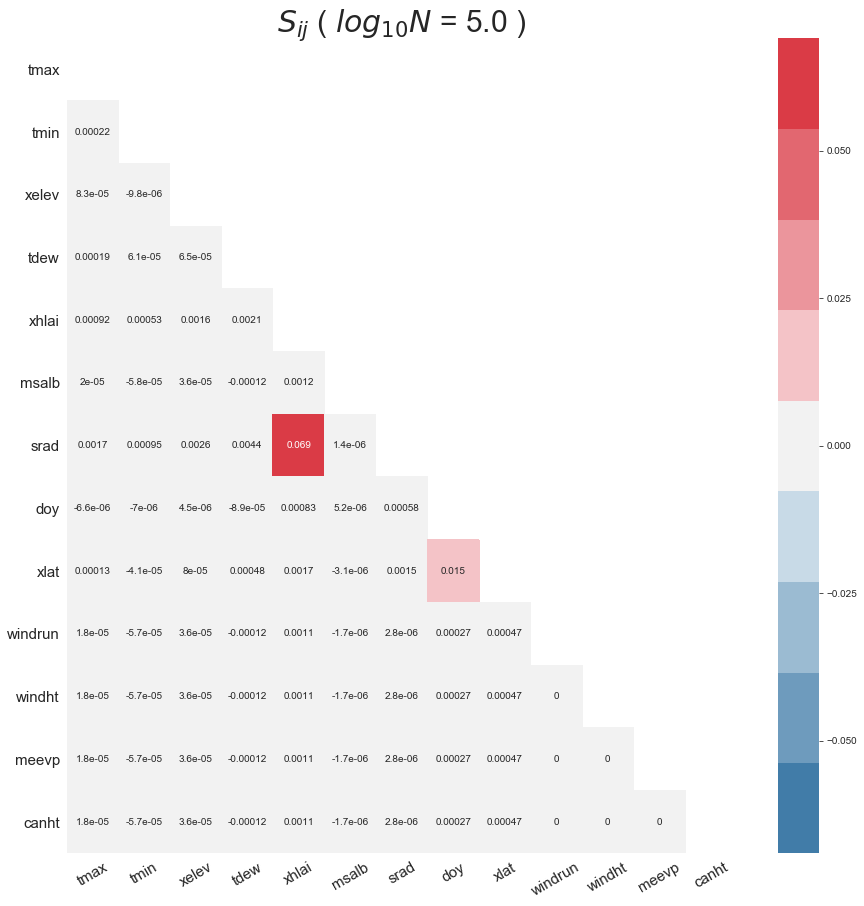

In [90]:
bounds = {
        'tmax':[5.0, 35.0],
        'tmin':[0.0, 23.9],
        'srad': [2.45, 27.8],
        'msalb': [0.18, 0.2],
        'xhlai': [-5.0, 5.0],
        'tdew': [8.0, 31],
        'windht': [1.0, 25.0],
        'windrun': [0, 900],
        'xlat': [-65.0, 65.0],
        'xelev': [0, 6000],
        'canht': [0.0, 5.0],
        'doy': [1, 365],
        'meevp': [0, 1],
}


SM = SensitivityModel(model, bounds, sample_list, method)

decimal=4
df_PETASCE_S1_xhlai, df_PETASCE_ST_xhlai = SM.generate_dataframe(decimal)

indices_lst = SM.generate_indices()

SM.sensitivity_plots(indices_lst, "S1")
SM.sensitivity_plots(indices_lst, "S2")

### SRAD : [0.0,  5.0] ; TMAX : [5.0,  35.0]

*** ALL OUTPUT FILES LIVE IN [.]


/Users/souratoshkhan/automates/notebooks/PETASCE_simple_lambdas.py:122: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return (meevp == "A")
/Users/souratoshkhan/automates/notebooks/PETASCE_simple_lambdas.py:191: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return (meevp == "A")
/Users/souratoshkhan/automates/notebooks/PETASCE_simple_lambdas.py:137: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return (meevp == "G")
/Users/souratoshkhan/automates/notebooks/PETASCE_simple_lambdas.py:200: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return (meevp == "G")


*** ALL OUTPUT FILES LIVE IN [.]


/Users/souratoshkhan/automates/notebooks/PETASCE_simple_lambdas.py:122: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return (meevp == "A")
/Users/souratoshkhan/automates/notebooks/PETASCE_simple_lambdas.py:191: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return (meevp == "A")
/Users/souratoshkhan/automates/notebooks/PETASCE_simple_lambdas.py:137: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return (meevp == "G")
/Users/souratoshkhan/automates/notebooks/PETASCE_simple_lambdas.py:200: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return (meevp == "G")


*** ALL OUTPUT FILES LIVE IN [.]


/Users/souratoshkhan/automates/notebooks/PETASCE_simple_lambdas.py:122: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return (meevp == "A")
/Users/souratoshkhan/automates/notebooks/PETASCE_simple_lambdas.py:191: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return (meevp == "A")
/Users/souratoshkhan/automates/notebooks/PETASCE_simple_lambdas.py:137: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return (meevp == "G")
/Users/souratoshkhan/automates/notebooks/PETASCE_simple_lambdas.py:200: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return (meevp == "G")


*** ALL OUTPUT FILES LIVE IN [.]


/Users/souratoshkhan/automates/notebooks/PETASCE_simple_lambdas.py:122: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return (meevp == "A")
/Users/souratoshkhan/automates/notebooks/PETASCE_simple_lambdas.py:191: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return (meevp == "A")
/Users/souratoshkhan/automates/notebooks/PETASCE_simple_lambdas.py:137: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return (meevp == "G")
/Users/souratoshkhan/automates/notebooks/PETASCE_simple_lambdas.py:200: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return (meevp == "G")


*** ALL OUTPUT FILES LIVE IN [.]


/Users/souratoshkhan/automates/notebooks/PETASCE_simple_lambdas.py:122: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return (meevp == "A")
/Users/souratoshkhan/automates/notebooks/PETASCE_simple_lambdas.py:191: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return (meevp == "A")
/Users/souratoshkhan/automates/notebooks/PETASCE_simple_lambdas.py:137: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return (meevp == "G")
/Users/souratoshkhan/automates/notebooks/PETASCE_simple_lambdas.py:200: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return (meevp == "G")


*** ALL OUTPUT FILES LIVE IN [.]


/Users/souratoshkhan/automates/notebooks/PETASCE_simple_lambdas.py:122: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return (meevp == "A")
/Users/souratoshkhan/automates/notebooks/PETASCE_simple_lambdas.py:191: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return (meevp == "A")
/Users/souratoshkhan/automates/notebooks/PETASCE_simple_lambdas.py:137: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return (meevp == "G")
/Users/souratoshkhan/automates/notebooks/PETASCE_simple_lambdas.py:200: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return (meevp == "G")


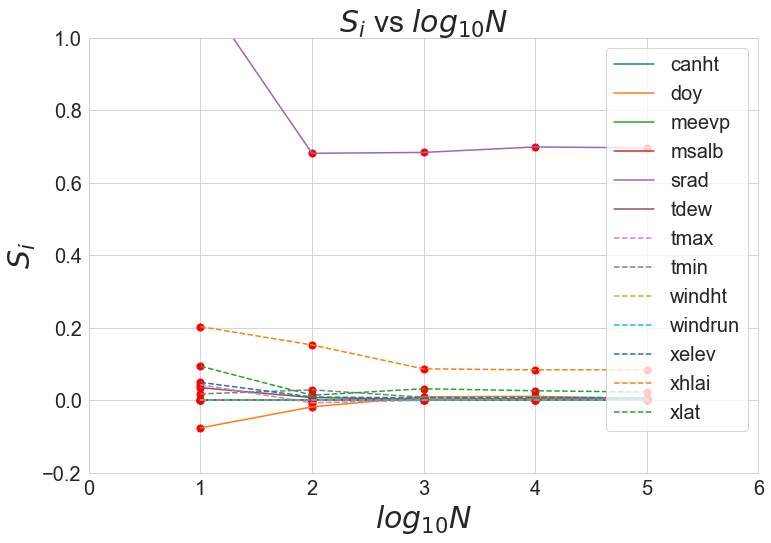

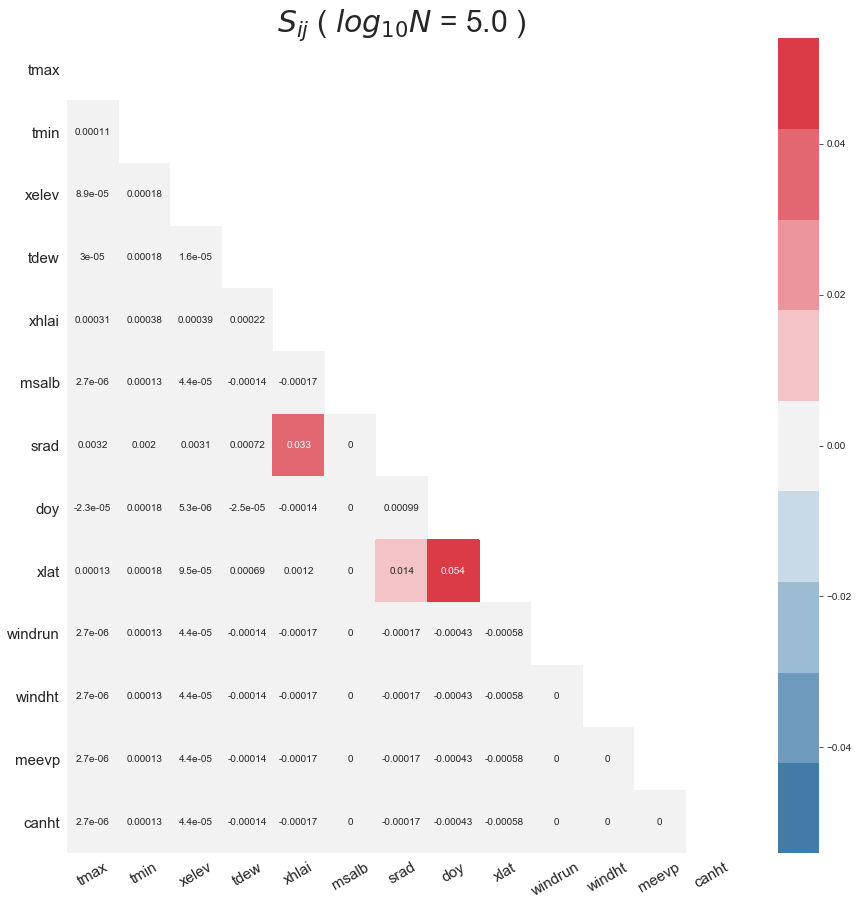

In [91]:
bounds = {
        'tmax':[5.0, 35.0],
        'tmin':[0.0, 23.9],
        'srad': [0.0, 5.0],
        'msalb': [0.18, 0.2],
        'xhlai': [0.0, 4.77],
        'tdew': [8.0, 31],
        'windht': [1.0, 25.0],
        'windrun': [0, 900],
        'xlat': [-65.0, 65.0],
        'xelev': [0, 6000],
        'canht': [0.0, 5.0],
        'doy': [1, 365],
        'meevp': [0, 1],
}


SM = SensitivityModel(model, bounds, sample_list, method)

decimal=4
df_PETASCE_S1_srad, df_PETASCE_ST_srad = SM.generate_dataframe(decimal)

indices_lst = SM.generate_indices()

SM.sensitivity_plots(indices_lst, "S1")
SM.sensitivity_plots(indices_lst, "S2")

## Take Home Message

In this demo we have shown how an initial sensitivity analysis of a scientific model can inform which variables to search for when doing single-variable range analysis. AutoMATES enables us to search the source code of the model automatically to determine where in the code variables with high S1 sensitivites cause functional differences. Using the parameter estimation from the TR component of AutoMATES and static progam analysis from the PA component of AutoMATES we can then perform a second set of sensitivty analysis upon a broken up range of the variable in question. This allows AutoMATES to deliver deeper insights about the sensitivity of a scientific model to its inputs without requiring a modeler to:
- manualy trek through the model code searching for the variable interactions of highest interest
- find correct bound parameters for variables of interest in the literature
- create new sensitivity analysis experiments as appropriate for the new ranges of a variable of interest

Key Insights:
- TMAX is the most important factor in Priestley-Taylor model
- Changes in the interval range of TMAX can significantly modify the order of Sobol indices.  For example, in the interval range [-10.0, 4.99], SRAD has a higher Sobol index.
- SRAD is the most dominant factor in all Penman-Monteith based models as well as in PETASCE. 
- Changes in TMAX or XHLAI do not alter the Ranking of Sensitivity Indices of SRAD  in PETPNO, PETPEN, PETDYN, and. PETASCE.
- In Penman models, changes in the interval ranges of SRAD can significantly alter the first and second order indices of SRAD as expected. Static code analysis however shows that SRAD do not appear in any conditional statements that will lead to evaulation of the response funciton (EO) in a piecewise manner. In all three cases, SRAD appears in the assignment of RNET and EO shares a linear relationship with RNET and hence SRAD.

PETPNO
--
``` fortran
      RNET= (1.0-ALBEDO)*SRAD - RADB
      WFNFAO = 0.0027 * (1.0+0.01*WINDSP)
      RNETMG = (RNET-G) / LHVAP * 1.0E6
      EO = (S*RNETMG + PSYCON*WFNFAO*VPD) / (S+PSYCON)
```
PETPEN
--

```fortran
      RNET= (1.0-ALBEDO)*SRAD - RADB
      RNETMG = (RNET-G)
      ET0 = ((S*RNETMG + (DAIR*SHAIR*VPD)/ra)/(S+PSYCON*(1+rs/ra)))
      ET0 = ET0/ (LHVAP / 1000000.)
      KC=1.0+(EORATIO-1.0)*MIN(XHLAI, 6)/6.0
      EO=ET0*KC
```
PETDYN
--
```fortran
      RNET= (1.0-ALBEDO)*SRAD - RADB
      RNETMG = (RNET-G)      
      EO=((S*RNETMG + (DAIR*SHAIR*VPD)/RAERO)/(S+PSYCON*(1+RTOT/RAERO))) (PETDYN)
```

- In PETASCE, changes in SRAD/TMAX/XHLAI interval bounds do not alter the ranking of indices at all.

## Results for TMAX : [5.0, 35.0]

- Tables below with a list of ST (total sensitivity index due to a parameter) and the first order indices (S1) for each model - PETPT, PETPNO, PETPEN, PETDYN, and PETASCE have been provided can summarize our results.
- SRAD in all cases has the highest ST and S1 indices within this range of TMAX

## 1. ST

In [98]:
from soboltable import table

frames = [df_PETPT_ST_set1, df_PETPNO_ST_set1, df_PETPEN_ST_set1, df_PETDYN_ST_set1, df_PETASCE_ST_set1]

Table = table(frames)
Table.style.highlight_max(color='lightgreen', axis=1)


,canht,clouds,doy,eoratio,meevp,msalb,srad,tavg,tdew,tmax,tmin,vapr,windht,windrun,windsp,xelev,xhlai,xlat
PETPT,,,,,,0,0.9346,,,0.0624,0.0176,,,,,,0.0007,
PETPNO,,0.067,,,,0,0.5909,0,0.1414,0.2284,0.0685,,,,0.0002,,0.0006,
PETPEN,,0.0985,,0.2499,,0,0.6095,0.0001,0,0.0437,0.0155,0.1267,0,,0,,0.0625,
PETDYN,0.0016,0.0837,,,,0,0.8414,0.0001,0.0114,0.0687,0.0227,,,,0.0026,,0.0045,
PETASCE,0,,0.0333,,0,0,0.758,,0.0338,0.0139,0.0093,,0,0,,0.0214,0.1906,0.0431


## 2. S1

In [99]:
frames = [df_PETPT_S1_set1, df_PETPNO_S1_set1, df_PETPEN_S1_set1, df_PETDYN_S1_set1, df_PETASCE_S1_set1]
Table = table(frames)
Table.style.highlight_max(color='lightgreen', axis=1)

,canht,clouds,doy,eoratio,meevp,msalb,srad,tavg,tdew,tmax,tmin,vapr,windht,windrun,windsp,xelev,xhlai,xlat
PETPT,,,,,,0,0.9193,,,0.0506,0.0143,,,,,,0.0005,
PETPNO,,0.0512,,,,0,0.53,0,0.1102,0.1813,0.048,,,,0,,0.0004,
PETPEN,,0.0203,,0.1475,,0,0.5613,0,0,0.0309,0.0113,0.0462,0,,0,,-0.0004,
PETDYN,0.0009,0.0707,,,,0,0.8231,0,0.0002,0.0511,0.0155,,,,0.0005,,0.0029,
PETASCE,0,,-0,,0,0,0.6999,,0.0211,0.0097,0.0064,,0,0,,0.0162,0.1516,0.0066


## Results for TMAX : [-10.0,  4.99]

- Using a different interval range of TMAX, PETPT S1 and ST values change considerably. Unlike the previous table, we see that TMAX in PETPT has the highest ST and S1. 
- However, in Peman-Monteith based models, i.e., PETPNO, PETPEN, PETDYN, SRAD still has the highest ST and S1 in all cases. 
- This is because that while TMAX and SRAD are the most influential parameters in PETPT and Penman models (PETPNO, PETPEN, PETDYN). As a result, changes in interval ranges of TMAX do not affect the ordering of Sobol indices in the latter models whereas it has a massive effect on the indices of PETPT parameters.

## ST

In [100]:
frames = [df_PETPT_ST_set2, df_PETPNO_ST_set2, df_PETPEN_ST_set2, df_PETDYN_ST_set2, df_PETASCE_ST_set2]

Table = table(frames)
Table.style.highlight_max(color='lightgreen', axis=1)

,canht,clouds,doy,eoratio,meevp,msalb,srad,tavg,tdew,tmax,tmin,vapr,windht,windrun,windsp,xelev,xhlai,xlat
PETPT,,,,,,0,0.3718,,,0.7673,0.012,,,,,,0.0003,
PETPNO,,0.0562,,,,0,0.5207,0,0.3492,0.0252,0.3316,,,,0.0006,,0.0008,
PETPEN,,0.0736,,0.2484,,0,0.6251,0,0,0.0079,0.0775,0.0958,0,,0,,0.0621,
PETDYN,0.0055,0.0593,,,,0,0.8171,0.0001,0.0128,0.0109,0.1204,,,,0.0141,,0.0073,
PETASCE,0,,0.0229,,0,0,0.7503,,0.0227,0.011,0.0272,,0,0,,0.041,0.1874,0.0296


## S1

In [101]:
frames = [df_PETPT_S1_set2, df_PETPNO_S1_set2, df_PETPEN_S1_set2, df_PETDYN_S1_set2, df_PETASCE_S1_set2]
Table = table(frames)
Table.style.highlight_max(color='lightgreen', axis=1)

,canht,clouds,doy,eoratio,meevp,msalb,srad,tavg,tdew,tmax,tmin,vapr,windht,windrun,windsp,xelev,xhlai,xlat
PETPT,,,,,,0,0.2245,,,0.6184,0.0063,,,,,,0.0001,
PETPNO,,0.0269,,,,-0,0.32,0,0.2018,0.0114,0.1886,,,,0.0002,,0.0004,
PETPEN,,0.0148,,0.1465,,0,0.5711,0,0,0.0055,0.0596,0.0351,0,,0,,-0.0004,
PETDYN,0.0035,0.0489,,,,0,0.7886,0.0001,0.0013,0.0078,0.0936,,,,0.0085,,0.0031,
PETASCE,0,,-0,,0,0,0.6915,,0.0142,0.0083,0.0205,,0,0,,0.0315,0.1483,0.0045


## Results for SRAD : [0.0,  5.0] ; TMAX : [5.0,  35.0]

- Altering the interval ranges of SRAD has a huge impact on PETPNO, PETPEN, and PETDYN. Table below shows that CLOUDS has the highest Sobol indices (both ST and S1).
- Modifying the range of SRAD does not affect the ranking in PETPT or PETASCE

## ST

In [113]:
frames = [df_PETPEN_ST_srad, df_PETDYN_ST_srad, df_PETPNO_ST_srad]
Table = table(frames)
Table.style.highlight_max(color='lightgreen', axis=1)

,canht,clouds,eoratio,msalb,srad,tavg,tdew,tmax,tmin,vapr,windht,windsp,xhlai
PETPEN,,0.5322,0.1368,0,0.1324,0,0,0.038,0.0145,0.5903,0,0.0001,0.0341
PETDYN,0.0033,0.7044,,0,0.3286,0.0001,0.0824,0.0831,0.0261,,,0.0204,0.0044
PETPNO,,0.4953,,0,0.1353,0,0.4238,0.366,0.0912,,,0.0008,0.0001


In [107]:
frames1 =[df_PETASCE_ST_srad]
Table = table(frames1)
Table.style.highlight_max(color='lightgreen', axis=1)

,tmax,tmin,xelev,tdew,xhlai,msalb,srad,doy,xlat,windrun,windht,meevp,canht
PETASCE,0.0113,0.0073,0.0122,0.015,0.1264,0,0.8002,0.109,0.1433,0,0,0,0


In [103]:
frames1 =[df_PETPT_ST_srad]
Table = table(frames1)
Table.style.highlight_max(color='lightgreen', axis=1)

,tmax,tmin,xhlai,msalb,srad
PETPT,0.0483,0.0136,0.0005,0,0.9532


## S1

In [108]:
frames = [df_PETPEN_S1_srad, df_PETDYN_S1_srad, df_PETPNO_S1_srad]
Table = table(frames)
Table.style.highlight_max(color='lightgreen', axis=1)

,canht,clouds,eoratio,msalb,srad,tavg,tdew,tmax,tmin,vapr,windht,windsp,xhlai
PETPEN,,0.1681,0.0571,0,0.1107,0,0,0.0173,0.0067,0.2195,0,0,-0.0002
PETDYN,0.0004,0.5117,,0,0.2122,0,0.0052,0.0352,0.0098,,,0.0016,0.0005
PETPNO,,0.1955,,0,0.0467,0,0.161,0.1507,0.0277,,,0.0001,0.0001


In [109]:
frames1 =[df_PETASCE_S1_srad]
Table = table(frames1)
Table.style.highlight_max(color='lightgreen', axis=1)

,tmax,tmin,xelev,tdew,xhlai,msalb,srad,doy,xlat,windrun,windht,meevp,canht
PETASCE,0.0062,0.004,0.0076,0.007,0.0843,0,0.6966,0.0047,0.0227,0,0,0,0


In [105]:
frames1 =[df_PETPT_S1_srad]
Table = table(frames1)
Table.style.highlight_max(color='lightgreen', axis=1)

,tmax,tmin,xhlai,msalb,srad
PETPT,0.0362,0.0102,0.0004,0,0.9375


## Final Result : Use "Unrealistic" Parameter Domains

- To get a complete picture of the most dominant parameters in these models, an unrealistic set of parameters is used in each model to determine the overall importance.
- As already mentioned, TMAX and SRAD have the largest Sobol indices in Priestley-Taylor and Penman-Monteith models, respectively. 

In [110]:
model = 'PETPT'
bounds = {
        'tmax':[-30.0, 60.0],
        'tmin':[-30.0, 60.0],
        'srad': [0.0, 30.0],
        'msalb': [0.0, 1.0],
        'xhlai': [0.0, 20.0]
    }


SM = SensitivityModel(model, bounds, sample_list, method)
decimal=4
df_PETPT_S1_new, df_PETPT_ST_new = SM.generate_dataframe(decimal)

model = 'PETPNO'
bounds = {
    'tmax':[-30.0, 60.0],
    'tmin':[-30.0, 60.0],
    'srad': [0.0, 30.0],
    'msalb': [0.0, 1.0],
    'xhlai': [0.0, 20.0],
    'tavg': [-30, 60],
    'tdew': [-30, 60],
    'windsp': [0.0, 10.0],
    'clouds': [0.0, 1.0]
}

SM = SensitivityModel(model, bounds, sample_list, method)
df_PETPNO_S1_new, df_PETPNO_ST_new = SM.generate_dataframe(decimal)

model = 'PETPEN'
bounds = {
    'tmax':[-30.0, 60.0],
    'tmin':[-30.0, 60.0],
    'srad': [0.0, 30.0],
    'msalb': [0.0, 1.0],
    'xhlai': [0.0, 20.0],
    'tavg': [-30, 60],
    'tdew': [-30, 60],
    'windsp': [1.0, 10.0],
    'windht': [1.0, 25.0],
    'vapr': [0.0, 20.0],
    'clouds': [0.0, 1.0],
    'eoratio': [0.0, 2.0]
}

SM = SensitivityModel(model, bounds, sample_list, method)
df_PETPEN_S1_new, df_PETPEN_ST_new = SM.generate_dataframe(decimal)


model = 'PETDYN'
bounds = {
    'tmax':[-30.0, 60.0],
    'tmin':[-30.0, 60.0],
    'srad': [0.0, 30.0],
    'msalb': [0.0, 1.0],
    'xhlai': [0.0, 20.0],
    'tavg': [-30, 60],
    'tdew': [-30, 60],
    'windsp': [0.0, 10.0],
    'canht': [0.0, 5.0],
    'clouds': [0.0, 1.0]
}

SM = SensitivityModel(model, bounds, sample_list, method)
df_PETDYN_S1_new, df_PETDYN_ST_new = SM.generate_dataframe(decimal)

model = 'PETASCE'
bounds = {
    'tmax':[-30.0, 60.0],
    'tmin':[-30.0, 60.0],
    'srad': [0.0, 30.0],
    'msalb': [0.0, 1.0],
    'xhlai': [0.0, 20.0],
    'tdew': [-30, 60],
    'canht': [0.0, 5.0],
    'windht': [1.0, 25.0],
    'windrun': [0, 900],
    'xlat': [-65.0, 65.0],
    'xelev': [0, 6000],
    'doy': [1, 365],
    'meevp': [0, 1]    
}

SM = SensitivityModel(model, bounds, sample_list, method)
df_PETASCE_S1_new, df_PETASCE_ST_new = SM.generate_dataframe(decimal)

*** ALL OUTPUT FILES LIVE IN [.]
*** ALL OUTPUT FILES LIVE IN [.]
*** ALL OUTPUT FILES LIVE IN [.]
*** ALL OUTPUT FILES LIVE IN [.]
*** ALL OUTPUT FILES LIVE IN [.]


/Users/souratoshkhan/automates/notebooks/PETASCE_simple_lambdas.py:122: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return (meevp == "A")
/Users/souratoshkhan/automates/notebooks/PETASCE_simple_lambdas.py:191: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return (meevp == "A")
/Users/souratoshkhan/automates/notebooks/PETASCE_simple_lambdas.py:137: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return (meevp == "G")
/Users/souratoshkhan/automates/notebooks/PETASCE_simple_lambdas.py:200: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return (meevp == "G")


## ST

In [114]:
frames = [df_PETPT_ST_new, df_PETPNO_ST_new, df_PETPEN_ST_new, df_PETDYN_ST_new, df_PETASCE_ST_new]

Table = table(frames)
Table.style.highlight_max(color='lightgreen', axis=1)

,canht,clouds,doy,eoratio,meevp,msalb,srad,tavg,tdew,tmax,tmin,vapr,windht,windrun,windsp,xelev,xhlai,xlat
PETPT,,,,,,0.006,0.411,,,0.7491,0.0481,,,,,,0.0097,
PETPNO,,0.0888,,,,0.008,0.3763,0.0008,0.2542,0.2999,0.3005,,,,0.0003,,0.0124,
PETPEN,,0.0654,,0.4459,,0,0.4324,0.0008,0,0.1335,0.1332,0.081,0,,0,,0.0432,
PETDYN,0.0041,0.1259,,,,0.0098,0.5777,0.0012,0.1351,0.2171,0.2168,,,,0.0153,,0.027,
PETASCE,0,,0.0349,,0,0,0.6063,,0.3302,0.1186,0.1188,,0,0,,0.0109,0.037,0.0441


## S1

In [115]:
frames = [df_PETPT_S1_new, df_PETPNO_S1_new, df_PETPEN_S1_new, df_PETDYN_S1_new, df_PETASCE_S1_new]

Table = table(frames)
Table.style.highlight_max(color='lightgreen', axis=1)

,canht,clouds,doy,eoratio,meevp,msalb,srad,tavg,tdew,tmax,tmin,vapr,windht,windrun,windsp,xelev,xhlai,xlat
PETPT,,,,,,0.0003,0.2145,,,0.5452,0.0227,,,,,,0.0017,
PETPNO,,0.0315,,,,0.001,0.2641,0.0004,0.1109,0.1649,0.1648,,,,0.0001,,0.0028,
PETPEN,,0.0101,,0.269,,0,0.3055,0.0004,0,0.0601,0.0606,0.0203,0,,-0,,0.0002,
PETDYN,0.0003,0.0266,,,,0.0008,0.4834,0.0006,0.0023,0.1038,0.1033,,,,0.0006,,0.0112,
PETASCE,0,,0.0002,,0,0,0.4632,,0.1693,0.0543,0.0547,,0,0,,0.0072,0.022,0.0014
